# Time Series with Python

This notebook covers the core techniques necessary to manipulate, interpret, and extract insights from time series data, predicting time series data using statistical and machine learning models.

## Table of Contents

- [Correlation and Autocorrelation](#corr)
- [Some Simple Time Series](#simple)
- [Autoregressive (AR) Models](#ar)
- [Moving Average (MA) and ARMA Models](#ma)
- [Putting It All Together](#all)
- [Case Study: Climate Change](#climate)

---
<a id='corr'></a>

## Correlation and Autocorrelation

From stock prices to climate data, time series data are found in a wide variety of domains, and being able to effectively work with such data is an increasingly important skill for data scientists. This notebook will introduce you to **time series analysis in Python**. After learning about what a time series is, you'll learn about several time series models ranging from autoregressive and moving average models to cointegration models. Along the way, you'll learn how to estimate, forecast, and simulate these models using statistical libraries in Python. You'll see numerous examples of how these models are used, with a particular emphasis on applications in finance.

`Time series analysis deals with data which is ordere in time.`

- Trend
- Seasonality pattern
- Slice by year
- Sample, resample data
- Gradual decrease in something
- Spike

`A first step when analyzing a time series is to visualize the data with a plot`. You should be able to clearly see a gradual decrease in searches for "diet" throughout the calendar year, hitting a low around the December holidays, followed by a spike in searches around the new year as people make New Year's resolutions to lose weight.

Like many time series datasets you will be working with, `the index of dates are strings and should be converted to a datetime index before plotting`.

In [78]:
# Import pandas and plotting modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = "data/dc26/"

In [33]:
df = pd.read_csv(path+'diet.csv', index_col='Date')
df.head()

,diet
Date,
6/26/2011,70
7/3/2011,71
7/10/2011,73
7/17/2011,74
7/24/2011,72


In [34]:
# Convert the date index to datetime
df.index = pd.to_datetime(df.index)

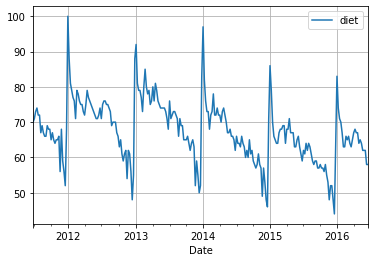

In [35]:
# Plot the entire time series diet and show gridlines
df.plot(grid=True)
plt.show();

In [36]:
df.head()

,diet
Date,
2011-06-26,70
2011-07-03,71
2011-07-10,73
2011-07-17,74
2011-07-24,72


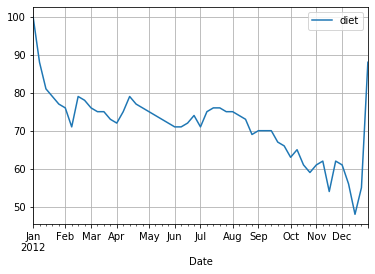

In [37]:
# Slice the dataset to keep only 2012
diet2012 = df['2012']

# Plot 2012 data
diet2012.plot(grid=True)
plt.show();

---
<a id='s2'></a>

## Merging Time Series With Different Dates

Stock and bond markets in the U.S. are closed on different days. For example, although the bond market is closed on Columbus Day (around Oct 12) and Veterans Day (around Nov 11), the stock market is open on those days. One way to see the dates that the stock market is open and the bond market is closed is to convert both indexes of dates into sets and take the difference in sets.

The pandas `.join()` method is a convenient tool to merge the stock and bond DataFrames on dates when both markets are open.

In [7]:
stocks = pd.read_csv(path+'stocks.csv', index_col='observation_date', parse_dates=True)
stocks.head()

,SP500
observation_date,
2007-06-11,1509.12
2007-06-12,1493.00
2007-06-13,1515.67
2007-06-14,1522.97
2007-06-15,1532.91


In [8]:
stocks.index

DatetimeIndex(['2007-06-11', '2007-06-12', '2007-06-13', '2007-06-14',
               '2007-06-15', '2007-06-18', '2007-06-19', '2007-06-20',
               '2007-06-21', '2007-06-22',
               ...
               '2017-05-26', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-05', '2017-06-06', '2017-06-07',
               '2017-06-08', '2017-06-09'],
              dtype='datetime64[ns]', name='observation_date', length=2519, freq=None)

In [9]:
bonds = pd.read_csv(path+'bonds.csv', index_col='observation_date', parse_dates=True)
bonds.head()

,US10Y
observation_date,
2007-06-08,5.12
2007-06-11,5.14
2007-06-12,5.26
2007-06-13,5.20
2007-06-14,5.23


In [10]:
# Convert the stock index and bond index into sets
set_stock_dates = set(stocks.index)
set_bond_dates = set(bonds.index)

#set_stock_dates

In [11]:
# Take the difference between the sets and print
print(set_stock_dates - set_bond_dates)

# Merge stocks and bonds DataFrames using inner join()
#  to get intersection of dates
stocks_and_bonds = stocks.join(bonds, how='inner')

{Timestamp('2010-11-11 00:00:00'), Timestamp('2013-11-11 00:00:00'), Timestamp('2016-11-11 00:00:00'), Timestamp('2012-10-08 00:00:00'), Timestamp('2011-11-11 00:00:00'), Timestamp('2009-10-12 00:00:00'), Timestamp('2007-10-08 00:00:00'), Timestamp('2016-10-10 00:00:00'), Timestamp('2017-06-09 00:00:00'), Timestamp('2014-10-13 00:00:00'), Timestamp('2008-10-13 00:00:00'), Timestamp('2014-11-11 00:00:00'), Timestamp('2009-11-11 00:00:00'), Timestamp('2008-11-11 00:00:00'), Timestamp('2015-10-12 00:00:00'), Timestamp('2011-10-10 00:00:00'), Timestamp('2007-11-12 00:00:00'), Timestamp('2013-10-14 00:00:00'), Timestamp('2010-10-11 00:00:00'), Timestamp('2012-11-12 00:00:00'), Timestamp('2015-11-11 00:00:00')}


In [12]:
stocks_and_bonds

,SP500,US10Y
observation_date,,
2007-06-11,1509.12,5.14
2007-06-12,1493.00,5.26
2007-06-13,1515.67,5.20
2007-06-14,1522.97,5.23
2007-06-15,1532.91,5.16
...,...,...
2017-06-02,2439.07,2.15
2017-06-05,2436.10,2.18
2017-06-06,2429.33,2.14


---
<a id='s3'></a>

## Correlation of Two Time Series (Stocks and Bonds)

Investors are often interested in the correlation between the returns of two different assets for asset allocation and hedging purposes. In this exercise, you'll try to answer the question of whether stocks are positively or negatively correlated with bonds. Scatter plots are also useful for visualizing the correlation between the two variables.

Keep in mind that `you should compute the correlations on the percentage changes rather than the levels`.

In [13]:
# Compute percent change using pct_change()
returns = stocks_and_bonds.pct_change()

returns.head()

,SP500,US10Y
observation_date,,
2007-06-11,NaN,NaN
2007-06-12,-0.010682,0.023346
2007-06-13,0.015184,-0.011407
2007-06-14,0.004816,0.005769
2007-06-15,0.006527,-0.013384


In [14]:
# Compute correlation using corr()
correlation = returns.SP500.corr(returns.US10Y)
print("Correlation of stocks and interest rates: ", correlation)

Correlation of stocks and interest rates:  0.4119448886249272


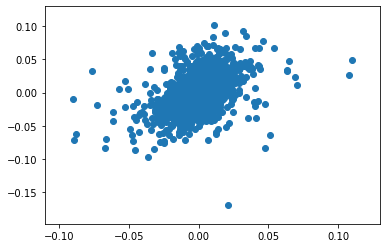

In [15]:
# Make scatter plot
plt.scatter(returns.SP500, returns.US10Y)
plt.show();

The positive correlation means that when interest rates go down, stock prices go down. For example, during crises like 9/11, investors sold stocks and moved their money to less risky bonds (this is sometimes referred to as a 'flight to quality'). During these periods, stocks drop and interest rates drop as well. Of course, there are times when the opposite relationship holds too.

---
<a id='s4'></a>

## Spurious Correlation - Flying Saucers Aren't Correlated to Flying Markets

Two trending series may show a strong correlation even if they are completely unrelated. This is referred to as **"spurious correlation"**. That's why when you look at the correlation of say, two stocks, `you should look at the correlation of their returns and not their levels`.

<img src="images/ts_001.svg" alt="" style="width: 400px;"/>

To illustrate this point, calculate the correlation between the levels of the stock market and the annual sightings of UFOs. Both of those time series have trended up over the last several decades, and the correlation of their levels is very high. Then calculate the correlation of their percent changes. This will be close to zero, since there is no relationship between those two series.

In [18]:
df = pd.read_csv(path+'levels.csv', index_col='Date', parse_dates=True)
df.head()

,DJI,UFO
Date,,
1941-01-01,110.96,1
1942-01-01,119.40,2
1943-01-01,135.89,9
1944-01-01,152.32,9
1945-01-01,192.91,9


In [21]:
# Compute correlation of df
levels = df.copy()
correlation1 = levels['DJI'].corr(levels['UFO'])
print("Correlation of levels: ", correlation1)

Correlation of levels:  0.9399762210726432


In [23]:
# Compute correlation of percent changes
changes = levels.pct_change()
changes.head()

,DJI,UFO
Date,,
1941-01-01,NaN,NaN
1942-01-01,0.076063,1.0
1943-01-01,0.138107,3.5
1944-01-01,0.120907,0.0
1945-01-01,0.266478,0.0


In [24]:
correlation2 = changes['DJI'].corr(changes['UFO'])
print("Correlation of changes: ", correlation2)

Correlation of changes:  0.06026935462405376


---
<a id='s5'></a>

## Simple Linear Regression - Looking at a Regression's R-Squared

**R-squared** measures how closely the data fit the regression line, so the **R-squared** in a simple regression `is related to the correlation between the two variables`. In particular, the magnitude of the correlation is the square root of the **R-squared** and the sign of the correlation is the sign of the regression coefficient.

In this exercise, you will start using the statistical package `statsmodels`, which performs much of the statistical modeling and testing that is found in R and software packages like SAS and MATLAB.

You will take two series, `x` and `y`, compute their correlation, and then regress `y` on `x` using the function `OLS(y,x)` in the `statsmodels.api` library (note that the dependent, or right-hand side variable y is the first argument). Most linear regressions contain a constant term which is the `intercept` (the α in the regression yt=α+βxt+ϵt). To include a constant using the function `OLS()`, you need to add a column of 1's to the right hand side of the regression.

In [26]:
x = pd.Series([1.2811550440412238, -0.6126310598985145, 0.9332222021268057, 2.2693265731638363, -1.427691082555, 0.6405188010777155, -1.596489626936219, 0.33561618750787203, -1.661094450815615, -0.892276781318839, -0.3853601714404014, 1.1750613930276552, 1.0795261289242912, -1.2035994956420473, -0.056172151726598965, -0.3766366045789261, 1.5701795772212934, -0.9428046774925836, 0.15111742087150695, 0.9206869830404033, 0.39865553922740776, 0.509308881338481, -0.33266116373611765, -2.23945925855725, -0.4534897919461296, 1.0290382457244724, -1.8780126981110872, 0.21017468558027702, -0.4757487221856649, -1.2186501112582493, 0.9308799884171601, -0.6028764223428251, -1.2009086565864688, -0.0964592154016757, 1.212574421217251, -0.6424298804905836, -1.37811844503333, 2.3018322938539786, 0.3649715099125608, 0.45720613554168227, -1.3774898420827786, -1.4383766335317467, 0.063973133855837, 0.44278722045348, -1.9974962921111783, -1.4044702210471958, 0.08692671859178444, 0.5570923022590792, 0.7522245332145279, -0.4545804023390465, -1.0680666881208938, -0.11323127134326061, 0.031636849769069254, -0.5913536163273568, -0.7743368977153091, 0.6947645888461771, 0.8286835284249676, -0.924767578153199, 1.2618915478818902, -2.3626119374754966, 0.14534783815545224, 0.049616126607182204, -1.6283838027917457, -0.6800270946068546, -0.5884337805404406, 0.7260916073821183, 0.8092150965860476, -0.6693518909217461, 0.9388824358296493, -1.5595639187088612, 0.8316986060383421, -1.1608014157128452, -0.5898791339712739, -0.09934721933319744, 0.2656448155523166, -0.18394678158088928, 0.9564584613417034, 1.0313898667732246, -0.6584946536221273, -1.3743996656695014, -0.0631732256437111, 0.026892033235163947, -0.8496921931994855, -1.729939107593855, -0.13857788040834806, 1.005633140702026, 0.7383585048100306, -0.06374618401822056, -0.43627521742932374, 0.41300383170708127, 0.23527973389250745, -1.4402823175412254, -0.037024592454535196, 0.3163210863597245, 0.4334010006371085, -0.1794067693088721, -0.22272937057979608, -0.9145161654283759, 0.23768785153671315, 0.2838865108117988, -0.8192423257468685, -1.9910712050577701, -0.04006354807978106, -0.12033738970715552, 0.15510748588618137, -0.4352447189222036, -0.0487281261986246, 1.0126578930049703, -0.7907201580971653, 0.7428329253873476, 1.100457607102351, 0.15812950730365105, -1.2496169877073868, 0.5361294618762135, 1.233762471342156, 1.7284866572391626, 0.25594780064858513, -0.41149149785151656, -1.0497931002530645, -0.6235509427190559, -0.22097480931607114, -0.46150241750214294, -0.4961601004936394, -1.0958358832877453, 1.5092875490667619, -1.6290323928216552, 0.28681646837921426, -0.7418999422719599, -0.5499656749845604, 0.6326764122049733, -0.029633564332853045, -0.012109250331289711, -1.0441640436490787, -0.5562011045733684, -1.0941654365809972, 0.8860495062314049, -1.5088203163123568, 1.1374329048126899, -1.5501735403499899, 0.6954523634231947, 0.9546853946527298, 1.3765439821968224, 0.19330216840911907, 1.892079712068668, 1.3575960296100273, 1.1969930896344374, -1.1278705031605591, 2.03058893387105, -1.7353520911623042, 0.026824698899590858, -0.9310507631310321, 0.7791126068047515, 0.4347688092705445, 0.8543492855148576, -0.36223449264905516, -0.9940674283863438, 1.1226780657187447, -1.3693434103086404, 0.09262208932661621, 0.16669856561892382, 0.4959097730434428, 0.05771982648856984, -0.6053809875603205, 1.6330030670912459, 0.288167641685169, 0.5595427949202992, 0.49161723704835875, 0.03710723132111678, -0.017796291447584375, -1.6570629840076838, 0.3972959690857464, -0.9938556824225638, 1.8668058033948733, 0.07302987315908709, 1.398213208859564, 0.27355501335685684, 0.6690414670643127, 1.1038295883597358, 1.3931754019172784, 1.5883723046544935, 0.5418476161290624, 0.5544303328617051, 0.9750753573422007, -1.916275205762016, -0.3626735851149104, 2.0628270289912463, -1.0723062135838064, 1.3360361211494085, 0.5475010717195191, -0.617524225013694, -0.9951149589811019, 1.0753160668536368, 0.3617901279608233, 0.9195681367049232, -0.4004585726579531, -0.6068603367567185, 0.048114274223299905, 1.6377358736628664, 0.33899410124172297, 0.21872786133555278, -1.6137386502993685, 0.18580232306052935, 0.22686320183666522, 1.5578421135323661, 0.1550583148874443, -0.3003998683723746, 0.32638341890705735, -1.370763314129386, -0.7321718364215666, -0.029719106687211696, 1.7250975811712936, 0.4285524229951472, 0.2782490086843458, 0.21799582474990986, 0.6062628073626953, 1.4581079982282943, -0.42615886544821197, -0.613083279799305, -0.5239485031323156, -1.670621825863721, -1.2640011981364627, 0.4132286076001853, -1.0532361755894544, 1.2835926349746098, -1.5735587350796931, -0.4084227724876398, 1.224872313494202, 0.3415187228815285, 0.19644259010643528, 0.18081070948849623, 0.3623181904942318, 1.689157463781665, -0.9965124679839346, -0.8218393586151007, -0.7848407321055315, -0.3228685919425816, -0.7392740033123055, -0.1500074064532319, 0.8107759705086444, 2.084423434792031, 0.8834937342698636, 2.8462671773195503, -0.14121234494487378, -0.8049187751604127, -2.321357750576519, 1.4134332889826897, 0.7466704197993697, 1.1506086948952838, -0.5060139080093885, -0.3354555917233457, -0.7174196055120188, 0.46658579812084167, -0.9298327945813356, 0.8456943454100372, 1.6050684916244604, -0.4352825695391445, -1.9727099686582816, 1.1880683084519628, -0.02323359841623244, -0.24158816746740822, 1.9061970426288974, 0.49757036585345893, 0.5293471899531691, -0.8387104275950436, -0.5384323931023147, -0.7710273505799191, -0.4109576100166529, -0.5375557392726514, -1.5226691060085205, 0.14313515560202128, 0.7624238993783363, 0.7334933564387248, 0.6587312472188919, 2.3626061416920234, 0.3191632013596961, 0.04647159859516381, -0.2755369854000762, -1.2814167482484604, -1.0777145898391958, -0.9643591443282876, 0.15456707448551382, 1.437029181593196, -1.3800682370220185, 1.0731570224196485, -0.05897203935250225, -0.1439819613811889, -1.2485507089306842, -1.0057958766239532, 0.2789286444875427, -1.8381512357957208, 0.4710816881100636, -0.913624085432763, 0.9228774883219917, -0.5269972810731411, -0.27566919969978776, -2.4872289245654806, 0.1324871295970721, -0.10288181143216761, 0.3028590233167439, -1.1743571235057015, -1.2880133585328295, -0.3417605743186503, -1.077587395061371, -2.151807645950538, -0.3927978678746878, 0.08400358092594723, -0.8270919285328677, -0.6129373404939361, 0.6952301625622106, 0.5021781114624926, 0.1799869140519854, -0.6192803879513986, 0.00587192506491817, 0.594271575339764, 0.5897645313049396, 0.5922167751763496, 2.134722295912065, 1.3347873183650223, -1.486619153082548, 0.08560166020524435, -1.6925581993269394, 1.011708416153619, -0.14020801309204117, 0.48184848501024724, 0.6718729525263696, -1.127862151776186, -0.2990782844837448, -0.7975916684903256, -0.3975826691867548, 2.142217744330889, 1.4066085892138767, 0.5273293230858743, 0.1378760563116852, 0.532649039316254, -1.223478422259192, -0.10299034282643785, -1.2822830722842427, 0.1032967267630437, 1.928093739383223, -0.7740374677171789, -0.7438198607084211, -0.18269039221875313, 0.7846498395908826, -0.10984657843530585, -0.3863608426004779, 1.5077979737496812, 0.00482917034885061, 1.732017154629424, -1.2295623137610412, -0.5725147309505427, -0.24956431539792898, -1.487353180389997, 0.4174945289618317, -1.6923016399179027, -0.23941151210717423, 0.965475945065727, 0.5473140277406429, 0.2719169871221121, 0.6603713592024104, -0.25902229365406354, -0.7604130478169479, -1.0078748877980297, 0.7870183151313934, -0.21502826189311067, -0.17072095044503943, 1.0236868222160658, 0.37755614563511675, 2.6108068431657854, 0.5246756173219759, 0.4836598162210405, 0.26742536748967183, 0.0169831633554079, 0.4562201011537283, -0.6606608098771884, 0.9949365427832687, -1.226735600080754, -1.6380411876107703, 2.041699248954565, 0.33493880002694376, 0.4529649856245742, -1.5153549153241226, 1.0909300176620387, 2.4913638757172443, 2.10651569366746, 1.9351030231528283, -2.1958407413708603, -0.4138797661100451, 0.250136395904108, 1.592751568266953, -1.2389426603316052, -0.26438440815028813, 1.6003122903891118, 0.4369099686809913, 0.66219670316823, 1.1573741156588628, 1.4986431755506244, 1.3255114982392833, -0.17931322235265917, -1.1957287571528918, 0.533196745245951, -0.3310345732826881, 0.9349535940920656, 1.5696533587044477, -0.5976302756882733, 0.630972928035347, -0.8272691085540191, 1.7440692032035177, -1.0589381321382874, 0.49376280519717664, 1.0662321134033914, -1.1480332637032122, 0.3315584422919956, -0.3645639530891268, 1.3957648949802663, 1.4190645340791712, 0.7116013566560508, 0.14958564285001907, -0.8387551985432976, -1.2123958029963737, 0.12306868449402704, 0.019751710655750914, 1.047685567212333, 0.29271014402798606, 0.5786548342762493, 0.7047096725632085, -2.708538556470341, 0.05010884493866954, -0.2969818564128184, 0.3999492635439395, 1.7223695598737703, -0.586845060734203, -0.026973741469146, -1.4616921654481712, 0.138495855842951, -1.123850873579895, 0.017135589417939627, 0.09308131402918762, 1.1230826990102114, -0.20143798281762954, -0.7258410981859367, 0.24627241367922775, 1.1296361715909322, 0.058552159550198345, -1.7983273468722822, 2.210210728664325, 2.249115280136353e-05, -0.5984532062176234, -0.45670278983757234, 1.1603754016024759, -1.0449496803465854, -0.4435199490079035, -1.8261954122445656, 0.2584637202654191, -0.4083742936784235, 0.693394936295836, -0.17069021353895084, 0.5684291527085978, 0.6665539259234277, 0.7259434644264395, -0.7818996934482328, -0.5742831908261057, -1.0057955675400962, 0.2767666945183962, -0.02657171937867959, 1.4859056991110522, 1.1814689108569423, -0.3200975323792521, 0.2979647582167218, -0.3232515902839842, 0.5459492822819827, 2.9272109032239864, 0.8037546198436225, -0.7499979255776861, 1.0195486390030897, -0.19318912479046815, 0.5013507507734484, -0.3154248752490127, -0.6909048361483536, -0.162428172141605, 0.6619320564839841, 1.541660251566514, 0.24676306444895935, -0.6081792360254962, 0.2230484458049995, -0.19688612727743685, -2.0280595004339546, -0.2019706712044319, 0.15767319852175163, -0.09038685208329725, -1.2842696550826431, 0.27116452125930596, -0.7124928794583623, 0.017356569438715625, 1.1873032421525376, 1.7072145367579399, 0.6655242675765024, 0.8527135331212987, 0.5509525519030603, -1.2461593572236154, -0.7068798069098832, 0.8567847697718416, -0.9234348937646064, -0.8806828886735357, -0.05609809998169541, 0.5019083657396824, -0.4157581652339636, 0.7576816160052998, -0.2833796697872356, -2.2915502845187197, -0.09944721684838555, 0.3980119421690809, 0.09454416205183548, 0.14329540595075083, -0.8734928742311916, 0.7584630765437268, -0.7908212321453724, -0.4320523265745874, 0.37025365268475396, -1.062001122245369, -0.4828920876000209, 0.6936722586624583, 0.5858808880619747, 1.4508861702159925, 0.7500862350496543, 0.5420294884948335, 1.0398706462749154, -0.1948557651599005, -2.385752240649883, -0.47077742637789227, 2.064509427221515, -1.386038447705097, -0.21990377100261563, -0.22630975846881524, -0.2588868206001651, -1.2646588934123528, -1.0834969364983877, -1.401409873741469, -0.0792912256992738, -0.2639577678483505, 0.032443527882877736, -0.1958118189742201, -0.2696672440142078, 2.356910173616174, -0.6625621350495404, -0.9823303116647341, -0.23929616612266164, -0.34032350329971356, -0.057851705966839494, -0.30298116057390284, -0.6066365014043973, 0.9809215742936962, -0.6705935056817571, -0.17471250370687091, -0.5779101748507249, -1.452565538806313, -0.6818093230131186, -0.875640737584392, 1.0829587238449638, 1.8344569102333776, 1.7031903105405986, -1.5062289827032123, 0.17890924580770518, -0.8351542433791986, 0.2710173607705894, 0.31965118866128406, 0.07953331906928739, -0.8475414408512983, 0.24929629756979074, 0.2938749017440937, 0.8625826904665663, -0.11273579413889787, 2.8006286023584983, -0.1117548423137034, 0.39703141240929996, -1.521600652092554, -1.0163254285070924, -0.28332438531049664, 1.2965563661393242, -0.9501724981207302, 0.2289047380394984, -0.5596777441867471, 0.020094441466944817, 1.0979926410447785, -1.3706395935376305, 1.5666130505215872, -0.7501925731978024, 0.6444428853456805, 0.5117080499010401, 0.017447261865881667, 1.2959498184802178, -1.2468030429927888, -0.8573379299224981, 0.8039631360433173, 0.9543085510513728, -1.545932002127972, 0.9610860616851591, -1.958830433328374, -0.4483478967243869, -0.3776644755498551, 0.5354507909342476, -1.0430895803398843, -1.0779232456335477, 0.33595254329514174, -0.5436533946867769, -0.5306417023748377, 0.8078920393134098, -0.8419042600738254, -1.424370805760945, 1.0103737412666025, -1.9600896409016224, 1.0225799813611687, -0.3422881659706962, -0.6327289414396146, 0.5735534796741496, 1.4513051087363864, 0.6070670062511726, 0.8195271507826488, -0.8639349441826176, 0.969726864583193, -0.38714731089393417, -1.423694462749488, -0.24029038589401666, -0.4859663413673385, 0.7421587411711145, 0.8955230500216699, -1.1931899850241667, -0.5250812576299323, 0.21044349786095048, -1.0435990843554972, -0.3553472314138764, -0.5745147739830379, 0.7270555706490947, -0.69252072507968, 0.0824295389407393, 0.5676522158489848, 0.4926951570286256, 0.12162848455760715, -0.3325245708296114, -1.040665362591346, -0.15104187318030327, 0.8482850141165379, 0.7282104379946829, 1.623223724188598, 1.065346721644724, -0.4631233870124684, -0.561463658403215, 0.08141045468279497, -0.6033751809042917, -1.2494181168901144, -1.0226185527491465, 1.6672766121243676, 0.5161077828412061, 0.7303143773731128, -1.2042140822667036, 0.42095035407325243, -0.5998653289544662, 0.4730008839090102, -1.9236000119268668, -1.1632113128844814, -0.34857698511954055, 0.6361644542059346, -0.28998923755127615, 0.5156222422474026, -2.0302343228889934, -1.408920553545117, -0.7164483539762333, 0.53851393409135, 1.632852293911881, -0.7059173661787806, -1.292958091755332, 0.22475214833323107, -0.7183152270319154, -0.0016646080338889222, -0.8232330902111494, 0.651173508629377, -0.23430488957409498, 0.9596102360167784, 0.28027084053186496, -0.3071623437513136, -0.150701948491389, 0.26539723370731777, 0.6575421788781195, -2.356978810174661, -0.4189421126781944, 0.33527442916251604, -0.6961444008576461, 0.23852841584644008, -0.9148663907490183, -0.6938629955169826, -0.6512048216975727, -0.44042201807582315, 0.4538387099487502, -0.9022531905831274, -0.43919529829075504, -0.48533301832222464, 1.400748938049492, -0.3041538855755456, 0.8022650307410149, 0.14423517799219773, -0.6162872691345818, -0.9003867648716256, -0.6426862410461465, -0.6385018025685305, -0.27749862681611087, -0.8898549936931711, -0.4845848557476576, -0.7462569079316493, -0.6660847909048132, -1.061698323614797, -0.4595916991858538, -0.4964001994536581, -1.1517433065966902, -0.7147352986264145, -0.979615491705565, -2.0022433379234714, -0.7920934071778448, 0.28918556795146877, -0.14459509154605615, 0.6300675586142113, 0.09113513829642259, 1.6182337171766665, 0.697616497978575, 0.40845000090522027, 0.0392003485912506, 1.2886297909140367, -0.9013774801911525, -0.7218805040877588, -2.3364088265360605, -0.15122718168423352, 1.5917319487562862, 0.10945483690096314, -0.5218476396593968, 0.014770133898636802, 0.5219232582969562, -1.6651425334274597, -0.9810023979643574, -0.49861418819806225, -0.37784158380837596, -1.9509977835799683, -0.7596789412979185, 0.5756436940108495, -0.1263915844750892, -0.2881655458555227, -0.21126222635427996, 0.8763471869337076, -0.16128480613787813, -0.595613530727245, 0.8223961660652714, 1.3938876633750859, -0.08179642293560137, -1.1508612743295161, 0.45892509993606106, 1.4622506372355752, 1.4968046003337594, 0.4330563169849272, 0.08146859954689607, -0.23758794588910806, 0.14433456436630293, 1.4297074738636055, -0.11910530737610853, 0.24994708657435719, -1.5397817734025403, 0.4710670256217842, -0.7528800491508506, 1.4973821201153297, -0.7370596961142618, -0.36600088826730276, 1.0788087412974006, 1.1097788135373696, 0.5606108417697564, 1.5254143138934957, -0.9083822366856663, 1.4745649737166788, 1.0676285887446368, 0.2614622875043119, -0.761594329523209, 0.16746351806632892, 0.29831306786322237, -0.3868078445771079, -0.3281181510361313, -0.20920587718194528, -0.6971623037562072, 0.8201147170205032, 0.8068979989605962, -0.14410762019304135, -0.03255522222679558, -1.0687328094882182, -0.27438958461986906, -1.5786072326056277, 0.0031124932782617726, 3.0875196913749394, -0.36685895820665904, 0.29001956648771726, 1.3781054114403108, -0.9691407832538603, -0.2555576493873456, 0.8684177508230642, -0.5193399002961957, -1.3421682606120884, 0.3147406832043353, 0.772758949221254, 0.632743021432991, 0.6282855528469061, -0.294330104752678, -1.1039735835170281, 0.4838728779399808, 1.091109943724447, -0.11402960847367027, 0.7216136659581276, -0.7952585606905005, 1.2900928276303572, 0.668708214494058, 1.6316989496194068, 0.4674668654867797, -1.4593356445396, 0.39301110318936955, -1.0780779185918286, 0.7399814906750249, -0.13169334753431958, 3.4530817839133077, 0.9851471428823663, 1.1702458168488377, -0.1374401186829724, -0.7140970042251803, -1.9273051033500685, 0.7415692564142079, 0.9767403767921218, -0.5386368829957875, 0.7941641292747003, -0.4426336706151123, 0.3611363176429492, 1.4393665592850737, 2.6426340756142896, -0.5173806148613016, -0.44752540165620003, 1.5207648982104383, -1.5542109065186518, -0.047589885387081685, 0.8049529740098417, 0.8584215654325545, 0.017913031835165235, 1.6261315194960824, 0.3903778618028171, -0.2824949808393406, -1.2822231331821135, 2.130088826538941, 0.01525282560618788, 3.753551482974148, 0.8933018228811488, 1.7967146397256244, -0.49568160024234537, 0.6706407731678474, 0.05766387793080424, -1.2120724687166047, -1.397301133108583, 0.1364103906471751, 0.22922870887051736, 0.09482754488813724, 0.4136402992332198, 0.9468518836081644, 2.3604601352516617, 0.7087840009586248, 0.6514681982249536, -1.5323044536529693, -0.6848120551306541, -0.5713992805749842, 0.13574232809169298, 0.08506206933983652, 1.0479594242103552, -0.03500546590392013, -1.4870046523111058, 1.4954443709311964, 0.5678162494115871, -1.2341719498736567, 0.7054584945121818, 0.12042410075608224, -0.029205904548573313, 0.8326703835870282, -0.2694083369965819, -0.2668229884277391, 0.45620238647435685, -0.34032229625850546, -0.6571342553469359, -0.52289564080822, 1.6514728722994687, 1.7022788554271675, 0.29758492780508267, 0.983691367511512, -0.33069743391009315, 0.14838735834684125, 0.4159273914669916, -1.7371164885762094, -0.9483051236350288, 0.2962478462192728, 1.130862479425501, -0.7521448321882552, 0.44055994741992077, -1.290473114630968, 0.38701573131336925, -1.2742461550579223, 0.15125253505998273, 0.24692691390378116, -1.4827692967810617, -0.7407891807851247, -0.3008623268715242, -0.9350653262601603, -1.0243160100912239, 0.40587665586893784, 0.813381859712616, 0.316200062837867, -0.45605550217223334, -0.10950542409640848, 1.8219947355667738, -0.11927902452886274, -0.18333975346505604, 0.8557516820631766, 0.14484051586829436, 0.7622419333896986, -1.8925454922311127, -0.818023396988202, -0.20544826880253692, -1.3199128745826836, 1.729563516423699, -0.09626352514342396, 1.1631185076895898, -0.5852350001243455, 0.7039075333859474, 0.617544368248742, -0.511282797504639, 1.3172490445252845, -1.0704715956704887, -0.5025752028483513, 0.04221309666716833, 1.4173558637443744, -0.06031795298007711, 0.18892275187271276, -0.04927489195075641, 0.8608987480623188, -0.5286370591510503, -0.7362899547896913, 1.6056121506761227, 1.1748273187350537, 0.5067017023831254, -2.085925519310575, 0.3396871039965605, -0.6564751973305406, -0.3331057193479064, -0.14696606994721095, -0.42788188240430064, -0.7232036028128643, -0.129793812318884, 0.4848980562907761, -1.1247681212903056, 0.5718077336743665, -0.4230129805204403, -0.5503507083933211, -0.7077830026673683, -1.4722981939474487, 0.7169901009692797, 2.6282023232584417, -0.11992815403676732, 0.4353676973975298, -1.1420916946045905, 1.3386924595354746, 0.9180706850375504, -0.6787382291510811, 0.4793461018723987, 1.397851133836866, -1.1313343392628266, -0.683984118806693, -0.8310011879258917, -0.14420594489065325, 0.9182054158071498, 1.216339774257903, 0.7748184342131297, 2.7340141733751624, 0.0005404319387118655, -1.6109057403686418, -1.0636523116621077, 0.04669677587569681, 0.23914254343351313, -0.09076924413605764, 1.2235224703671055, 0.8581408680020675, -0.1437251143017076, 1.740802785806922, -0.32070034322663066, -0.12664089914099344, -1.3801308078906984, 1.035784268964063, -0.05602888306554742, 0.16418240278246704, 0.7863503496394391, 0.25154225043142625, 0.4682238397718219, 1.0890322480832832, 0.7436922974132252, -1.6115703065738287, 1.011224254361624, 1.5719710523592254])
y = pd.Series([-0.8351286009190672, -0.06100441499537612, -0.194677330631589, -2.4611421320699467, 1.040072990892944, -0.6828739396020767, 1.3107639678267742, -0.5298639831872226, 2.639054920254874, 1.0649845894270087, 1.052035801676665, -0.6492146582173699, -1.3647372713719814, 0.5646740628725941, -0.3292163536905029, -0.8749304916011758, -1.883174191714396, 0.8651524394848811, 0.15666513226527481, -0.793844987778514, -1.1712928255286783, -0.2526950984933609, 0.3273704057637023, 2.424119190394595, 1.454417921600079, -1.493598456173196, 1.5211081928494008, 0.26803795383150913, 1.2605576813226307, 1.6968970520786513, -0.5754065968246665, 0.009752477415448239, 1.561915809634276, -0.0077827232736593565, -1.123344542892297, 0.27072607156943584, 0.8874343256221449, -1.8368522031971426, -0.42133365389976307, -1.175414516001151, 1.0694182669881944, 1.7994158301635967, -0.5496034510258208, -0.985044049537418, 2.071036645930695, 0.8376931544450931, 0.43982915406535145, -0.09596389771269319, -1.3619875450452867, 0.285007545705001, 0.18352831476965914, 1.2752281128590326, -0.016368025541275942, -0.24134723602942829, 0.056375833843262335, -0.13893642883047652, -0.6045181655598098, 1.0494242786206278, -1.410579011186635, 1.4569839407534417, -0.3922580739101969, 0.28499606976433933, 1.5075322031407763, 0.9035176816076788, 0.3362393315340148, -1.2180458429821857, -0.6653524863688425, 0.8140115574040573, -0.13122804960129275, 1.4012502554784658, -0.7734647082014946, 1.309618437647121, 0.4950340199543207, 0.7900884968784077, -0.2015556492345248, 0.3108326180697597, -1.7958196412162415, -0.9562837890101289, 0.4211697757054076, 1.3103694234018777, -0.023570054303233504, 0.2881583503543797, 0.4479052396498257, 1.2402283884003817, 0.015864002170548185, -1.0392280889458745, -0.7057533944065573, 0.7220130094387418, 0.16292693533091762, -0.35040371958031274, 0.4174684307050774, 1.2797612914123162, -1.1065249909203736, -0.7537217897041183, -0.2582792036745885, 0.16600466912717265, 0.16632778775671594, -0.5304555619213652, -0.28726180106259136, -0.3813550423126317, 0.5517614900302444, 2.2988869499939746, -0.05235864358750514, -0.28900037602902284, -0.030476428364102706, 0.6944898693279178, -0.5845631094753875, -0.2916632456888246, 0.9560190622554623, -0.74120276252537, -1.347291281771406, -0.31985980150945287, 0.615143470662628, -1.1509086120876026, -1.17828298784928, -1.3913462901200206, -0.22518472313119609, 0.21732632728409726, 0.9628803906739333, 0.5345051781176213, 0.34604375756453193, 0.025778700949339116, 0.3535181985885683, 0.1332115507220299, -1.3467497524558527, 2.002482017436798, -1.0435253128347786, 0.7058620298051606, 0.6015288311009992, 0.6904611111905807, -0.041583058263442725, -0.24885630285378202, 0.8859602961150294, 0.6834794488264708, 1.2820754649058856, -1.4792728779721538, 1.2365965693647982, -1.4368954464740926, 0.9150349787144477, -0.9936577469384562, -1.4843326819574272, -1.582793263425021, -0.4985425104162844, -1.3315708369058545, -1.2332555735860795, -0.8981127007256928, 0.7353897756251918, -1.7194233851753498, 1.9212563409773007, 0.33978339077341935, 0.5603156861554537, -0.5058098466895491, 0.15403511311095938, -0.5186663257741796, 0.30568989517621464, 1.2982046637971552, -0.8363635677419465, 1.311006771933953, -0.3920973979405682, 0.14017971042533597, -1.0980191786092972, -0.6747515949956524, 0.41455952135834273, -1.78890508717576, -0.08730808916749108, 0.2761770828489287, -0.519522716313831, -0.16350248730212608, 0.259842285864462, 0.9552703090152659, -0.5975454381796642, 0.8343511124979328, -1.8275715472142229, 0.007357470866249986, -0.6294375283426397, -0.35776392846515653, -1.0853982206347939, -1.2797235485339382, -0.4734952482197081, -2.0929770660193125, -0.2406531601128485, -0.25213031345049236, -0.9485595561718797, 1.4834867550363189, 0.45521438502146405, -2.3262226647219744, 1.1327147851674544, -1.0271111332391483, -0.3864814910521105, 0.11722834295539541, 0.5445433254828663, -1.4701291926643976, -0.31286354900968205, -0.5864748140108972, 0.08973536473366796, 1.1261058916010336, -0.1442576147331307, -1.8199810453177645, -0.22925709425946764, -0.10959569693089637, 1.376753860943283, -0.7712788503736197, 0.20998084418460666, -1.8556224018418037, 0.22511925219840134, 0.44595162773616676, -0.11088269984684684, 0.606478957058956, 0.6880051085490362, -1.0628575995947624, -0.9657025138773654, -0.9136757654733096, -0.6114889769485324, 0.4604154281775538, -0.5372621991055229, -0.778268897850732, -0.05764535435919853, 1.149734070677476, -0.2092121091733229, 1.8093128333586201, 1.0176342671395302, -0.36383247546020187, 1.117183260206731, -1.166427504298986, 1.602988199266382, -0.15620395419868643, -1.5100569077149304, -0.2949813474272129, 0.5199522901637373, 0.29521358812747733, 0.2856512031937996, -1.956918449897968, 0.9197724014996493, 0.9940461549432806, 1.0590129550423013, 0.9903149317539083, 1.1837178740427534, -0.11020391792137656, -0.4749433371781799, -2.6690112923427125, -0.9942333813580929, -2.283349897856185, 1.0287445749254598, 1.2657184205737533, 2.0660175316732308, -1.5173466757092178, -0.8615351571905977, -0.8966450081164234, 0.4939737594811782, 0.27192857530052045, 0.7485638954826769, -0.050862984996839285, 1.5279603287615164, -1.0847064029232791, -1.7117580111758084, 0.3758920787990269, 1.7912112936648938, -0.9338254981311711, 0.269041239924053, 0.35060352969420205, -2.2309251076178858, -0.6531847485271, -0.3447290272489765, 0.33262521992775607, 0.8003958685249337, 0.13692565854859848, 0.44789540455929583, 1.3355443573541301, 1.5730451112880557, 0.13948070865982107, -1.4111891230665945, -0.187638343980973, 0.013243362197729269, -3.072426434616361, 0.07804947297679296, -0.08924880637945112, -0.5128548489001585, 0.9760750830094682, 1.0461755585253074, 1.1178687801853213, -0.05337978977617685, -1.4343327845105922, 1.9651101843833167, -0.8470074346493587, 0.42442974830423524, 0.0395558010498794, 1.345326196281462, 1.4415546340271979, -0.35361343763228753, 1.9237847350303976, -1.0077573572133016, 0.9853096167802949, -0.6211939804749285, -0.21558974556080812, 0.8718902074054266, 2.502837825731818, 0.5860048041907306, 0.22601843601179708, -0.9264425309488689, 0.6047991987791652, 0.9355350050934457, 0.17527559483491692, 1.212129996285403, 1.6671722546010892, 0.4139698006528976, 0.6297140643644672, 0.3139029645907753, 0.42706670492387344, -0.22750854651242883, -0.671998676579982, 0.2431602828428717, 0.5144468523538015, -0.524697682245477, -0.8869196935567136, 0.298742909953898, -0.7245155562878318, -1.8661387374721192, -1.7402264782147339, 0.5452665418204603, 0.27258496682237804, 1.2810800520845667, -0.20473996011401668, -0.18905922818964352, -0.9167888952990743, -0.1852059605567809, 0.6027125075608392, 0.11922698339665362, 0.7276654726847182, 0.3266522643178294, -2.1211976117402878, -1.072482605927704, -0.7978992083312557, 0.12052125541513824, 0.20175742263808755, 1.990659299330785, -0.5597616267088866, 1.096087800275874, 0.17769656555972038, -1.1995285876412514, 0.9315781085278209, 0.9928966083438362, 0.045049531009922, -0.6562037083491528, 0.5942678096267451, 0.004797525042239186, -1.564845506871891, -0.04869705977825815, -1.2515017358911724, 0.8613779951720202, 0.9986336465646574, -0.17461716554909484, 1.6577064243902737, -0.07186756079736258, 1.4699648631778892, 1.1084191586892835, -1.2111096173220595, -0.6181200759656393, -0.13739717717278396, -0.938834936851383, 0.32830098343116143, 0.9434821803499186, 0.49673119671066546, 0.03960232855322794, 0.5492725554776009, 0.36093692831721746, 0.5735719614904095, -0.3946939152059685, -2.1160693536411297, -0.5518635680566477, -0.5456807148119283, -0.28667423479323867, -0.08594587515020048, 0.12896714068903015, 1.0575370799085069, -0.4328691796731137, 0.9792456604321654, 1.3324932571029853, -1.5490818521503682, 0.1019538053880786, -1.0172456892719937, 0.8860052812538409, -1.95207865452835, -2.9560654830566793, -2.1224389504593404, -2.424476973402556, 2.350184993909178, -0.31094255442247554, -0.22862159240944485, -1.5363218522876991, 1.0831968948433943, -0.6488688721809964, -1.1272966611367068, -0.8526896514981273, -0.6878963364437285, -1.100794214133822, -1.1524998517053378, -0.7350695563049733, -0.19887046298447833, 0.581035065845718, -0.5332305217730403, -0.5672321558963068, -0.8597169089303115, -1.0032889586016045, 0.3676549816070723, 0.20154385703720945, 0.9973082794075395, -1.0152848661244311, 0.9925692251760728, -0.5777960012661414, -1.2767738153751444, 0.33964045300533535, -0.2806852246508079, -0.1626726809919302, -0.9086753281969658, -0.9679821133040046, -0.2287017484302373, -0.6712474761904214, 0.8309776075195926, 1.6113998109762353, -0.3241661494135685, 0.06531279533116849, -0.6711587435663129, -0.48189390293423895, -0.4753407715250453, -0.6443492043894243, 2.6845636770790255, -0.7959221408352424, -0.1990813019576479, -0.3321482864839041, -1.6519500762163362, 0.006764297216013477, -0.7917251445212186, 1.609524556893827, -0.21158658130421582, 1.081738758533241, 0.662016196505634, -0.5817226860721069, -0.4841648088498559, -0.023211398741577356, 1.1721412087903582, -0.6809357811910692, -1.931887685845895, -0.4580015305105127, 1.8245062266219392, -1.5757357083224197, 0.31525391701854727, 0.731077334942962, 0.5634798083057991, -0.9963677766855772, 0.9510095967894265, 0.6311659192646828, 1.7131620415049307, -0.31075718420451387, -0.6079712440343344, -0.5592822574491567, -0.1867851236334443, -0.7274641784212689, -0.8959971340932692, -0.32552144880940265, 1.1994116402176425, 0.25751174579805997, 0.8652584328547716, 0.3217037211381487, 0.13716049965096547, -1.2681085218036827, -0.7289157387036611, -0.6799475756041976, -0.3999449039817398, 0.6231138473325765, -0.09298085509382946, -3.2465164901782626, -1.3646425370290651, 1.120814201007724, -0.49270553055824784, 0.004606261917645445, -0.849404447840968, 0.6061829861423851, -0.2259803829117142, 0.41528120242872174, -0.6425898256870864, -2.0917191379940356, -0.3852879872746276, 0.07737006632550128, -0.44208462240686014, 0.8323957730786525, 1.326631787764381, -0.29556756172921794, 0.031462053121549025, 0.06846815404386546, 1.6067059132638761, -0.26033687150137474, 0.9851994841659273, -0.8112693032942038, -1.1220193480659464, -1.775367428150278, -0.21864482871235116, -1.7166268838508927, -0.2670778495323081, 0.8394959526625937, 0.2098330002179524, -0.6029486915581515, 0.4764982356085541, 0.04506436899875718, -0.4511530380389726, -1.0725875065282233, 0.6634583586114344, -0.5897161023344912, 0.22593429888349945, 1.9154979347685708, -0.07156146139542914, -0.3267207266534765, -0.4793387070970653, 0.38545938086748527, 0.9642971299389009, -0.6750892246414598, 1.323537265071567, 0.26910683304195515, -0.02498421762860199, 0.2759339588922596, 0.8009899035818229, -1.0357822141384223, -0.8901036618630953, -1.310867202679047, -0.7815628434531199, -0.42791063166025234, -0.9301846361158219, 0.5649673152228756, 1.450135885822667, 0.15363016218797498, -1.6881207700896754, 1.2108972111953078, 0.1912477816463337, 0.6200973167111856, 0.41351983396980974, 1.1910197089897347, 0.7158871721876354, 1.7313754203157241, -0.8663634540184704, -0.2645634670436962, 0.6165388990391645, 0.1162021576778026, 0.39741389527177323, -2.2491599323467155, 0.5465810303146639, 0.9252325061115448, 1.2558596740012449, -0.5282244055567069, -0.7139897685127677, 0.8885407174426136, 0.7498826888948223, -0.27626958615143227, 0.7978121589570587, 0.22463377612490337, 0.3036219218847386, 1.5206939474266443, 0.48791214187544585, -0.14478996902488192, -1.0970071130274728, -0.7435177758190721, -1.5484987928781087, 1.7214670990104932, -0.42583558677259536, 0.47726231473696157, 0.038096052897151116, -0.2805155223625518, -0.5132399922408362, 1.4705396030720284, -0.36806556637150684, -0.05291475247876026, -0.9021724106554729, 0.39986577222888964, -2.620221202571141, 0.5624246103349794, -0.6288460130766073, 0.822535721205695, 2.15935617933679, 0.6474002907697215, -1.60717294563803, 1.1119812403517202, -0.12476249608497518, 0.4286013618780339, -0.03633159309394091, -0.9532767239907178, 2.1451966050479645, -1.311419010975985, 0.56660671312809, -1.2351290037741947, -0.35517920546109255, -0.2906648448779417, -1.1391047395660956, 0.8322709351313324, 0.016811048440167207, -0.47767425446309264, -1.224620872006959, 1.2181942107787327, -0.7035588452833823, 1.8516467744656862, 1.0501941704766498, 0.256953520471082, -1.1728245091137073, 1.1240160761185238, 1.5201840920392329, -0.8667444118086592, 0.2607877167620652, 0.2036606154765182, -0.8709450461805627, 0.9789930688211912, 0.8727052412665653, -1.050248959756164, 2.261639558143545, -1.0566310270913808, 0.0879641689887834, 0.5627641014888486, -0.009949510620575518, -1.8814375338069855, -0.9861615054025421, -0.601074061339009, 1.2736010499868522, -1.0177656092236762, 0.49447989411611204, 1.121675811107636, 0.06443226401984596, 0.0034689738695751183, -1.0686742438906895, -0.20327072084000522, 1.0980901612023022, -0.18797220682385504, -0.1390616280261179, 1.1897505980676946, 0.4885108439456383, -0.050134919134401, -0.08535468633790749, 0.9135491124267225, 0.2124816186721891, -1.2742763336812466, -0.25212865228164333, 0.3318276218970302, 0.3525786106287421, 1.5470792059323741, -0.3422570211804259, -0.9204881581661553, 0.01316341403563022, -1.6519606801021933, -1.013111337887004, 0.2820479552777713, 0.47263499017623906, -0.26829597409628075, 0.6653149184703697, 1.817390508429139, 0.05688688992439631, -1.2262119474031368, -0.4110824615891767, -0.4987084352785847, 0.6632521116301329, -1.164992319734768, -0.14487071556052242, -0.24062371480622027, 2.088361703429373, 1.279110670671242, 0.2542493976331204, -0.11096657857793092, 0.44038553510059264, -0.6699295955570451, 2.0000465866003365, 1.1762569151543973, 0.8460488856960432, -0.24846778832539768, -1.3758737786327224, 0.8280394084692945, 1.2625026425566397, -0.06597364397623037, 0.9731556523617573, -0.4434148149501292, 0.4701260817399749, -0.9439388371569425, -0.12180971530516568, -1.2542533108639282, -0.07710865015291997, -0.17603499466635414, 0.2950426056823578, -0.6214892965784424, -0.8953758772257824, 1.9593735415796323, 0.09958572299840592, -0.6510682451385197, 0.8656865759426796, -0.013609070052617028, 0.5344150561018873, 0.37292834968210176, 0.9822316450476345, 0.3465401042268712, -0.5717370481593201, 0.5971054703288382, -0.34236822612223855, 0.02223063152501999, -1.1687725906574817, 0.10586944426631484, 0.21337214590510878, -0.23422172147043996, 0.6552898120563176, 1.0244656411284943, 0.8409496290315752, 0.6194268145648701, 0.1562878693937707, 0.287888193886669, 0.9309153610206364, 0.6997029925032779, 0.31878825262511706, 0.5701143012807507, 0.6978033278005473, 0.29645831542061674, 0.33009348152386797, 0.800348934463625, 1.0690801175262108, 1.5810489275007527, 0.3958601539534113, 0.04281354616881958, 1.0745930617700512, -0.054950273680818396, -0.4045871868644608, -1.5454852016847376, -0.3185952077687233, -0.6215926970923221, 0.7305507571259972, -0.8335395096830446, 0.802567438371458, 0.5947482213539691, 2.2862782880716557, 0.00552874477217613, -1.709417717939578, 0.5617781652973668, 0.43715335055980953, 0.13162092831509203, -0.21681758902938303, 1.502737480383597, 1.372907435310837, 0.5486688465014347, 0.28062040088401696, 1.6297181252760515, 1.4527355642894983, -0.05426108354313248, 0.15427972976539, -0.4335169417881578, 0.8568382011803327, -0.4974058190480708, -0.32738069328901365, 1.3496321241965947, -0.725886713891028, -1.4126739073506405, 0.8657214303512696, 1.8854088632627228, -0.5685662517104995, -1.7820779034972276, -1.3333315305007223, -0.9256273304326064, -0.6113616832331479, 0.36479673242228206, -0.47110257310565057, -1.1813444496459788, 0.3267534955325383, -0.34740544104937127, 1.2711920562999022, -0.13838837257970832, -0.16239722670141785, -1.7929148468748217, 1.0374410281852575, 0.6467365826435185, -0.8100123096600219, -0.6861337314986262, -0.4346638307931161, -2.128655774250894, 1.2177395000370108, -0.8996308771909305, -1.0587017116974322, -0.6744261177245441, 1.5151409625322352, 0.5149839442728665, -0.24987599015708883, -0.13048809645106724, 0.6455025719498002, -0.5473682454010533, 0.019627662862032696, -0.7613413282985465, -0.6934503519759025, -0.5850725868256018, 0.2948816300949554, 0.9047985827761954, -0.3942433390587412, 2.251667356221582, -0.05894343129140028, -2.6245361983282276, 0.7303594772766099, -0.49995451917562633, -1.0301688826703248, 1.4717564854918987, 0.10947456718482437, -1.1822501238511427, 0.3920837621715219, 1.8575175444530967, -0.8584012859084936, -0.2963052111610501, -0.3885697714869025, -0.47481787633773975, 0.7352081350739362, 1.6899257763805653, -0.549621655536818, -1.1965116085691776, -0.06662676646404964, -0.2600533788212141, 0.97375136675372, -1.2002337976178175, -0.08029700605296085, -1.8816125018560808, -0.6761251158864803, 0.4073289815726317, -0.012557251751150106, 0.8325228343702813, -0.5851500736714067, 0.16273136414455638, -3.9571685184156546, -0.6975843905737343, -1.638311891490591, -0.4383899498731495, 0.5390559572860592, 1.6456863317405426, -0.381813516712245, -0.30074647336334515, 0.40273764267681067, 0.48071112756120604, 0.5099290379543837, 0.10269664410803683, -1.5203963064975958, -2.8811812178653438, 1.1355330381166666, 0.733728056466949, -1.8241428894973772, 1.3199335876913987, -0.3126683869300254, -1.0152637656368146, -0.43021374462763834, 0.43774566758539546, -1.0780922109710034, 0.4322037424391844, -0.3853746142222261, 1.2211837374674344, -2.065155791036126, 0.4659994235011272, -3.239761434249477, -0.03185757015558928, -1.552831668631661, 0.3069061540090139, -0.8377846308107615, -0.618218395526103, 0.7236256247824069, 0.5972652740685637, -0.20899607885924681, 0.19843980984266132, -0.299619802946286, 0.025079303856235437, -1.403308713220161, -1.4538469569917025, -1.5519746708504625, -0.9253665117890424, 1.324395199438293, -0.1160490200892289, -0.16596481627273799, -0.47556696161315065, 0.19865412914889677, -1.5561811954881166, 0.342368979767648, 1.2759682548933864, -1.4119828118737403, -0.9812295297180748, 1.5108705191089844, -0.7138265475096489, -0.04659109590334553, -0.8205278901107289, -1.070586489272524, -0.21460841610333678, 0.09631320741008491, -1.0242871391502386, 0.5300497061994761, 0.9027834176968405, 0.6937663940700887, -1.776298629948592, -1.0899486001439687, 0.27026714926143897, -1.0247765298666414, 0.1827134956160951, 0.5144562902463607, -1.59564219165742, 1.3830743733075401, 1.2398496146033884, -0.12615248531274562, -1.092448104166287, 0.4058527095300118, -0.30076387552194483, 1.2890622273482375, -0.4524948562808326, 0.9873531167931605, -0.43400815098799417, -0.15135933523977815, 0.5326303447803972, 0.3420580637655695, 0.8552439475444681, 1.005706640275822, 0.6024218879610441, 0.27365147653603067, -0.7251604071340673, -0.4034552233141353, 0.33552298351653376, -0.1161510741361051, -1.7356404162116643, 0.7374057890601887, -0.440392863540994, -0.6140808783233639, -0.019937835373290917, 0.07396203397441399, 1.475923263020116, 0.954004231593583, -0.1790158879202037, 1.8410322470217249, -1.1108473941141084, -0.17107654683025816, -0.7405820189209587, 0.19430488124406078, -0.877213133892288, -0.3815138372168757, 0.22701151896720698, -1.913831653047473, 0.6255788269572155, -0.28593281727612363, 0.816225208825358, -1.1715237715870714, 0.4708081327913606, -0.06691172858963793, 0.30545798867900137, -0.7748330455340461, 1.0509783310521734, 0.23006360328719602, -1.4228692443994069, -0.7972294037423477, -0.05429329907326862, 2.0580539716569923, 0.11356072183027066, 1.4174575043243387, 0.05007901143451323, -0.13192938376661625, 0.03959328983755052, 1.035130682671959, 0.14123199175408116, 0.10196031148966289, 1.1899346797509782, -1.0981103018572353, 0.13766300733678496, 0.3774152067624021, 0.8005419199122669, 0.4732653940626776, 0.27438769057062173, -2.2513567954103326, 0.694911145290376, 0.09697499121064398, 1.2300944273844185, -0.930384419140953, -0.9795073550971156, 1.1671257547001797, -0.19895080857955924, -1.60910629513907, 1.7321157382917554, 0.620553808442369, 0.8206132246477095, 0.1837319831396932, -0.5935619708743829, -0.8693714074655606, -1.0977405113428507, -2.8038168150266114, 0.3693376381270472, 0.9444620352467245, 0.8561298846744425, -0.0937742156636077, -0.6371228668572977, 0.4535243360287085, -1.2322246907687768, -0.3680297493571115, 0.8184385530730466, -1.2782960057055743, -0.003607082617419526, 0.8269922697547579, 1.7478379673018143, -0.8972091198449379, 0.6114756025487191, -0.15721848971159086, -0.4875726168694107, -0.1683700970680314, -0.4470976422645183, -1.0170804253102823, -0.4309430601515828, 1.9897793997817539, -1.1719066305299213, -1.5659023361893578])


In [45]:
# Import the statsmodels module
import statsmodels.api as sm

In [46]:
# Compute correlation of x and y
correlation = x.corr(y)
print("The correlation between x and y is %4.2f" %(correlation))

The correlation between x and y is -0.90


In [48]:
# Convert the Series x to a DataFrame and name the column x
dfx = pd.DataFrame(x, columns=['x'])
dfx.head()

,x
0,1.281155
1,-0.612631
2,0.933222
3,2.269327
4,-1.427691


In [49]:
# Add a constant to the DataFrame dfx
dfx1 = sm.add_constant(dfx)
dfx1.head()

/Users/ksatola/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,x
0,1.0,1.281155
1,1.0,-0.612631
2,1.0,0.933222
3,1.0,2.269327
4,1.0,-1.427691


In [50]:
# Regress y on dfx1
result = sm.OLS(y, dfx1).fit()

# Print out the results and look at the relationship between R-squared and the correlation above
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     4471.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):               0.00
Time:                        22:32:56   Log-Likelihood:                -560.10
No. Observations:                1000   AIC:                             1124.
Df Residuals:                     998   BIC:                             1134.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0052      0.013     -0.391      0.6

Notice that the two different methods of computing correlation give the same result. The correlation is about -0.9 and the R-squared is about 0.81

---
<a id='s6'></a>

## A Popular Strategy Using Autocorrelation

**Autocorrelation** is self-correlation with a lag of 1 day (lag 1 autocorrelation).

One puzzling anomaly with stocks is that investors tend to overreact to news. Following large jumps, either up or down, stock prices tend to reverse. This is described as **mean reversion in stock prices**: prices tend to bounce back, or revert, towards previous levels after large moves, which are observed over time horizons of about a week. A more mathematical way to describe **mean reversion** is to say that `stock returns are negatively autocorrelated`.

This simple idea is actually the basis for a popular hedge fund strategy. If you're curious to learn more about this hedge fund strategy (although it's not necessary reading for anything else later in the course), see [here](https://www.quantopian.com/posts/enhancing-short-term-mean-reversion-strategies-1).

You'll look at the **autocorrelation** of weekly returns of `MSFT` stock from 2012 to 2017. You'll start with a DataFrame `MSFT` of daily prices. You should use the `.resample()` method to get weekly prices and then compute returns from prices. Use the pandas method `.autocorr()` to get the autocorrelation and show that the autocorrelation is negative. Note that the `.autocorr()` method only works on Series, not DataFrames (even DataFrames with one column), so you will have to select the column in the DataFrame.

In [52]:
df = pd.read_csv(path+'MSFT.csv', index_col='Date', parse_dates=True)
df.head()

,Adj Close
Date,
2012-08-06,26.107651
2012-08-07,26.377876
2012-08-08,26.438896
2012-08-09,26.587088
2012-08-10,26.517351


In [54]:
# Convert the daily data to weekly data
MSFT = df.resample(rule='W').last()
MSFT.head()

,Adj Close
Date,
2012-08-12,26.517351
2012-08-19,27.114212
2012-08-26,26.815865
2012-09-02,27.044012
2012-09-09,27.158091


In [55]:
# Compute the percentage change of prices
returns = MSFT.pct_change()
returns.head()

,Adj Close
Date,
2012-08-12,NaN
2012-08-19,0.022508
2012-08-26,-0.011003
2012-09-02,0.008508
2012-09-09,0.004218


In [56]:
# Compute and print the autocorrelation of returns
autocorrelation = returns['Adj Close'].autocorr()
print("The autocorrelation of weekly returns is %4.2f" %(autocorrelation))

The autocorrelation of weekly returns is -0.16


Notice how the autocorrelation of returns for MSFT is negative, so the stock is 'mean reverting'.

## Are Interest Rates Autocorrelated?

When you look at daily changes in interest rates, the autocorrelation is close to zero. However, if you resample the data and look at annual changes, the autocorrelation is negative. This implies that while short term changes in interest rates may be uncorrelated, long term changes in interest rates are negatively autocorrelated. A daily move up or down in interest rates is unlikely to tell you anything about interest rates tomorrow, but a move in interest rates over a year can tell you something about where interest rates are going over the next year. And this makes some economic sense: over long horizons, when interest rates go up, the economy tends to slow down, which consequently causes interest rates to fall, and vice versa.

The DataFrame `daily_rates` contains daily data of 10-year interest rates from 1962 to 2017.

In [59]:
df = pd.read_csv(path+'daily_rates.csv', index_col='DATE', parse_dates=True)
df.head()

,US10Y
DATE,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


In [60]:
daily_rates = df

# Compute the daily change in interest rates 
daily_diff = daily_rates.diff()
daily_diff.head()

,US10Y
DATE,
1962-01-02,NaN
1962-01-03,-0.03
1962-01-04,-0.04
1962-01-05,0.03
1962-01-08,0.01


In [61]:
# Compute and print the autocorrelation of daily changes
autocorrelation_daily = daily_diff['US10Y'].autocorr()
print("The autocorrelation of daily interest rate changes is %4.2f" %(autocorrelation_daily))

The autocorrelation of daily interest rate changes is 0.07


In [62]:
# Convert the daily data to annual data
yearly_rates = daily_rates.resample(rule='A').last()
yearly_rates.head()

,US10Y
DATE,
1962-12-31,3.85
1963-12-31,4.14
1964-12-31,4.21
1965-12-31,4.65
1966-12-31,4.64


In [63]:
# Repeat above for annual data
yearly_diff = yearly_rates.diff()
autocorrelation_yearly = yearly_diff['US10Y'].autocorr()
print("The autocorrelation of annual interest rate changes is %4.2f" %(autocorrelation_yearly))

The autocorrelation of annual interest rate changes is -0.22


Notice how the daily autocorrelation is small but the annual autocorrelation is large and negative

---
<a id='simple'></a>

## Some Simple Time Series

## Autocorrelation Function

## Taxing Exercise: Compute the ACF

You computed autocorrelations with one lag. Often we are interested in seeing the autocorrelation over many lags. The quarterly earnings for H&R Block (ticker symbol HRB) is plotted below, and you can see the extreme cyclicality of its earnings. A vast majority of its earnings occurs in the quarter that taxes are due.

<img src="images/ts_002.svg" alt="" style="width: 400px;"/>

You will compute the array of autocorrelations for the H&R Block quarterly earnings that is preloaded in the DataFrame `HRB`. Then, plot the autocorrelation function using the plot_acf module. This plot shows what the autocorrelation function looks like for cyclical earnings data. The ACF at `lag=0` is always one, of course. In the next exercise, you will learn about the confidence interval for the ACF, but for now, suppress the confidence interval by setting `alpha=1`.

In [64]:
# Import the acf module and the plot_acf module from statsmodels
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [67]:
df = pd.read_csv(path+'HRB.csv', index_col='Quarter', parse_dates=True)
df.head()

,Earnings
Quarter,
2007-01-01,-0.36
2007-04-01,-0.38
2007-07-01,0.07
2007-10-01,1.85
2008-01-01,-0.34


In [69]:
HRB = df
# Compute the acf array of HRB
acf_array = acf(HRB)
print(acf_array)

[ 1.         -0.22122696 -0.39856504 -0.26615093  0.83479804 -0.1901038
 -0.3475634  -0.23140368  0.71995993 -0.15661007 -0.29766783 -0.22097189
  0.61656933 -0.15022869 -0.27922022 -0.22465946  0.5725259  -0.08758288
 -0.24075584 -0.20363054  0.4797058  -0.06091139 -0.20935484 -0.18303202
  0.42481275 -0.03352559 -0.17471087 -0.16384328  0.34341079 -0.01734364
 -0.13820811 -0.12232172  0.28407164 -0.01927656 -0.11757974 -0.10386933
  0.20156485 -0.0120634  -0.07509539 -0.0707104   0.10222029]


/Users/ksatola/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


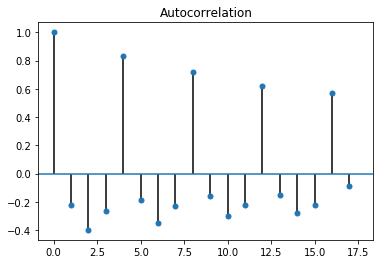

In [72]:
# Plot the acf function
plot_acf(HRB, alpha=1)
plt.show();

Notice the strong positive autocorrelation at lags 4, 8, 12, 16,20, ...

## Are We Confident This Stock is Mean Reverting?

You saw that the autocorrelation of MSFT's weekly stock returns was `-0.16`. That autocorrelation seems large, but is it **statistically significant**? `In other words, can you say that there is less than a 5% chance that we would observe such a large negative autocorrelation if the true autocorrelation were really zero?` And are there any autocorrelations at other lags that are significantly different from zero?

Even if the true autocorrelations were zero at all lags, in a finite sample of returns you won't see the estimate of the autocorrelations exactly zero. In fact, the standard deviation of the sample autocorrelation is 1/N‾‾√ where N is the number of observations, so if N=100, for example, the standard deviation of the ACF is 0.1, and since 95% of a normal curve is between +1.96 and -1.96 standard deviations from the mean, the 95% confidence interval is ±1.96/N‾‾√. This approximation only holds when the true autocorrelations are all zero.

You will compute the actual and approximate confidence interval for the ACF, and compare it to the lag-one autocorrelation of -0.16 from the last chapter. The weekly returns of Microsoft is pre-loaded in a DataFrame called returns.

In [75]:
returns = pd.read_csv(path+'returns.csv', parse_dates=True, index_col='Date')
returns

,Adj Close
Date,
2012-08-19,0.022508
2012-08-26,-0.011003
2012-09-02,0.008508
2012-09-09,0.004218
2012-09-16,0.008400
...,...
2017-07-09,0.007689
2017-07-16,0.047797
2017-07-23,0.013877


The autocorrelation of weekly MSFT returns is -0.16
The approximate confidence interval is +/- 0.12


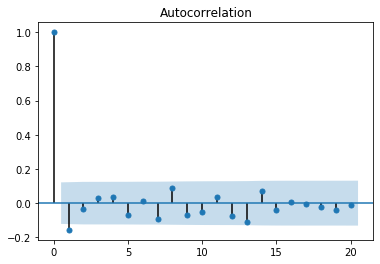

In [76]:
# Import the plot_acf module from statsmodels and sqrt from math
from statsmodels.graphics.tsaplots import plot_acf
from math import sqrt

# Compute and print the autocorrelation of MSFT weekly returns
autocorrelation = returns['Adj Close'].autocorr()
print("The autocorrelation of weekly MSFT returns is %4.2f" %(autocorrelation))

# Find the number of observations by taking the length of the returns DataFrame
nobs = len(returns)

# Compute the approximate confidence interval
conf = 1.96/sqrt(nobs)
print("The approximate confidence interval is +/- %4.2f" %(conf))

# Plot the autocorrelation function with 95% confidence intervals and 20 lags using plot_acf
plot_acf(returns, alpha=0.05, lags=20)
plt.show();

Notice that the autocorrelation with lag 1 is significantly negative, but none of the other lags are significantly different from zero.

## White Noise

## Can't Forecast White Noise

A white noise time series is simply a sequence of uncorrelated random variables that are identically distributed. Stock returns are often modeled as white noise. Unfortunately, for white noise, we cannot forecast future observations based on the past - autocorrelations at all lags are zero.

You will generate a white noise series and plot the autocorrelation function to show that it is zero for all lags. You can use `np.random.normal()` to generate random returns. For a Gaussian white noise process, the mean and standard deviation describe the entire process.

Plot this white noise series to see what it looks like, and then plot the autocorrelation function.

The mean is 0.018 and the standard deviation is 0.050


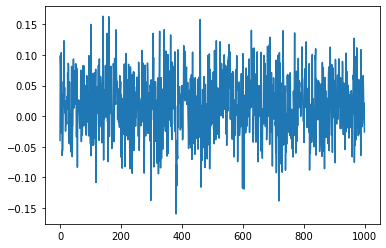

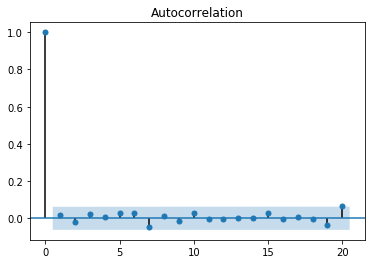

In [79]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Simulate wite noise returns
returns = np.random.normal(loc=0.02, scale=0.05, size=1000)

# Print out the mean and standard deviation of returns
mean = np.mean(returns)
std = np.std(returns)
print("The mean is %5.3f and the standard deviation is %5.3f" %(mean,std))

# Plot returns series
plt.plot(returns)
plt.show()

# Plot autocorrelation function of white noise returns
plot_acf(returns, lags=20)
plt.show();

Notice that for a white noise time series, all the autocorrelations are close to zero, so the past will not help you forecast the future.

## Random Walk

## Generate a Random Walk

Whereas stock returns are often modeled as white noise, stock prices closely follow a random walk. In other words, today's price is yesterday's price plus some random noise.

You will simulate the price of a stock over time that has a starting price of 100 and every day goes up or down by a random amount. Then, plot the simulated stock price. If you hit the "Run Code" code button multiple times, you'll see several realizations.

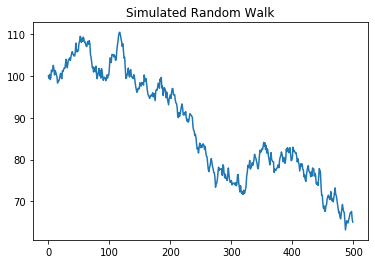

In [81]:
# Generate 500 random steps with mean=0 and standard deviation=1
steps = np.random.normal(loc=0, scale=1, size=500)

# Set first element to 0 so that the first price will be the starting stock price
steps[0]=0

# Simulate stock prices, P with a starting price of 100
P = 100 + np.cumsum(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk")
plt.show();

## Get the Drift

In the last exercise, you simulated stock prices that follow a random walk. You will extend this in two ways in this exercise.

- You will look at a random walk with a drift. Many time series, like stock prices, are random walks but tend to drift up over time.
- In the last exercise, the noise in the random walk was additive: random, normal changes in price were added to the last price. However, when adding noise, you could theoretically get negative prices. Now you will make the noise multiplicative: you will add one to the random, normal changes to get a total return, and multiply that by the last price.

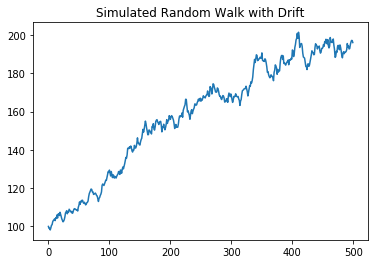

In [82]:
# Generate 500 random steps
steps = np.random.normal(loc=0.001, scale=0.01, size=500) + 1

# Set first element to 1
steps[0]=1

# Simulate the stock price, P, by taking the cumulative product
P = 100 * np.cumprod(steps)

# Plot the simulated stock prices
plt.plot(P)
plt.title("Simulated Random Walk with Drift")
plt.show();

This simulated price series you plotted should closely resemble a random walk for a high flying stock.

## Are Stock Prices a Random Walk?

Most stock prices follow a random walk (perhaps with a drift). You will look at a time series of Amazon stock prices, pre-loaded in the DataFrame AMZN, and run the 'Augmented Dickey-Fuller Test' from the statsmodels library to show that it does indeed follow a random walk.

With the ADF test, the "null hypothesis" (the hypothesis that we either reject or fail to reject) is that the series follows a random walk. Therefore, a low p-value (say less than 5%) means we can reject the null hypothesis that the series is a random walk.

In [84]:
AMZN = pd.read_csv(path+'AMZN.csv', parse_dates=True, index_col='Date')
AMZN

,Adj Close
Date,
1997-05-15,1.958333
1997-05-16,1.729167
1997-05-19,1.708333
1997-05-20,1.635417
1997-05-21,1.427083
...,...
2017-07-27,1046.000000
2017-07-28,1020.039978
2017-07-31,987.780029


In [85]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Run the ADF test on the price series and print out the results
results = adfuller(AMZN['Adj Close'])
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(4.025168525770736, 1.0, 33, 5054, {'1%': -3.4316445438146865, '5%': -2.862112049726916, '10%': -2.5670745025321304}, 30308.64216426981)
The p-value of the test on prices is: 1.0


According to this test, we cannot reject the hypothesis that Amazon prices follow a random walk. In the next exercise, you'll look at Amazon returns.

## How About Stock Returns?

In the last exercise, you showed that Amazon stock prices, contained in the DataFrame AMZN follow a random walk. In this exercise. you will do the same thing for Amazon returns (percent change in prices) and show that the returns do not follow a random walk.

In [86]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Create a DataFrame of AMZN returns
AMZN_ret = AMZN.pct_change()

# Eliminate the NaN in the first row of returns
AMZN_ret = AMZN_ret.dropna()

# Run the ADF test on the return series and print out the p-value
results = adfuller(AMZN_ret['Adj Close'])
print('The p-value of the test on returns is: ' + str(results[1]))

The p-value of the test on returns is: 2.5655898083473664e-22


The p-value is extremely small, so we can easily reject the hypothesis that returns are a random walk at all levels of significance.

## Stationarity

## Is it Stationary?

Here are four time series plots. Which one is stationary?

<img src="images/ts_003.png" alt="" style="width: 400px;"/>

Correct: A, This is white noise, which is stationary.

## Seasonal Adjustment During Tax Season

Many time series exhibit strong seasonal behavior. The procedure for removing the seasonal component of a time series is called seasonal adjustment. For example, most economic data published by the government is seasonally adjusted.

You saw earlier that by taking first differences of a random walk, you get a stationary white noise process. For seasonal adjustments, instead of taking first differences, you will take differences with a lag corresponding to the periodicity.

Look again at the ACF of H&R Block's quarterly earnings, pre-loaded in the DataFrame HRB, and there is a clear seasonal component. The autocorrelation is high for lags 4,8,12,16,... because of the spike in earnings every four quarters during tax season. Apply a seasonal adjustment by taking the fourth difference (four represents the periodicity of the series). Then compute the autocorrelation of the transformed series.

<img src="images/ts_004.svg" alt="" style="width: 400px;"/>


            Earnings
Quarter             
2007-01-01       NaN
2007-04-01       NaN
2007-07-01       NaN
2007-10-01       NaN
2008-01-01      0.02
2008-04-01     -0.04
2008-07-01     -0.05
2008-10-01      0.26
2009-01-01     -0.05
2009-04-01      0.02


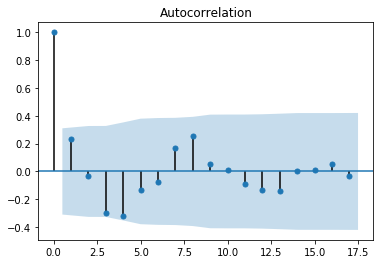

In [87]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Seasonally adjust quarterly earnings
HRBsa = HRB.diff(4)

# Print the first 10 rows of the seasonally adjusted series
print(HRBsa.head(10))

# Drop the NaN data in the first three three rows
HRBsa = HRBsa.dropna()

# Plot the autocorrelation function of the seasonally adjusted series
plot_acf(HRBsa)
plt.show();

By seasonally adjusting the series, we eliminated the seasonal pattern in the autocorrelation function.

---
<a id='ar'></a>

## Autoregressive (AR) Models

## Simulate AR(1) Time Series

You will simulate and plot a few AR(1) time series, each with a different parameter, ϕ, using the `arima_process` module in statsmodels. In this exercise, you will look at an AR(1) model with a large positive ϕ and a large negative ϕ, but feel free to play around with your own parameters.

There are a few conventions when using the arima_process module that require some explanation. First, these routines were made very generally to handle both AR and MA models. We will cover MA models next, so for now, just ignore the MA part. Second, when inputting the coefficients, you must include the zero-lag coefficient of 1, and the sign of the other coefficients is opposite what we have been using (to be consistent with the time series literature in signal processing). For example, for an AR(1) process with ϕ=0.9, the array representing the AR parameters would be ar = np.array([1, -0.9])

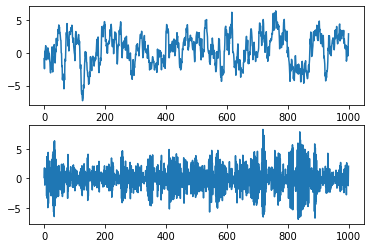

In [88]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess

# Plot 1: AR parameter = +0.9
plt.subplot(2,1,1)
ar1 = np.array([1, -0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
plt.subplot(2,1,2)
ar2 = np.array([1, 0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)
plt.show()

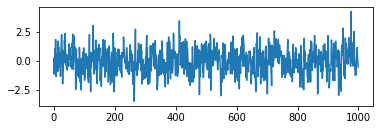

In [90]:
# Plot 3: AR parameter = +0.3
plt.subplot(2,1,2)
ar3 = np.array([1, -0.3])
ma3 = np.array([1])
AR_object3 = ArmaProcess(ar3, ma3)
simulated_data_3 = AR_object3.generate_sample(nsample=1000)
plt.plot(simulated_data_3)
plt.show();

The two AR parameters produce very different looking time series plots, but in the next exercise you'll really be able to distinguish the time series.

## Compare the ACF for Several AR Time Series

The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter. For example, if the AR parameter, ϕ=+0.9, the first-lag autocorrelation will be 0.9, the second-lag will be (0.9)2=0.81, the third-lag will be (0.9)3=0.729, etc. A smaller AR parameter will have a steeper decay, and for a negative AR parameter, say -0.9, the decay will flip signs, so the first-lag autocorrelation will be -0.9, the second-lag will be (−0.9)2=0.81, the third-lag will be (−0.9)3=−0.729, etc.

The object simulated_data_1 is the simulated time series with an AR parameter of +0.9, simulated_data_2 is for an AR parameter of -0.9, and simulated_data_3 is for an AR parameter of 0.3

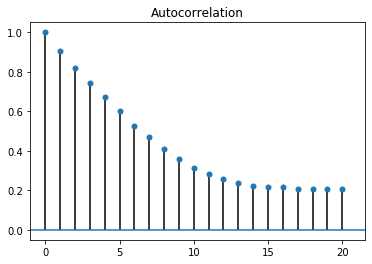

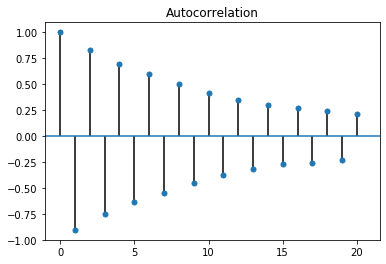

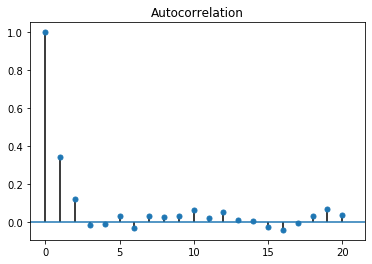

In [91]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot 1: AR parameter = +0.9
plot_acf(simulated_data_1, alpha=1, lags=20)
plt.show();

# Plot 2: AR parameter = -0.9
plot_acf(simulated_data_2, alpha=1, lags=20)
plt.show();

# Plot 3: AR parameter = +0.3
plot_acf(simulated_data_3, alpha=1, lags=20)
plt.show();

The ACF plots match what we predicted.

## Match AR Model with ACF

Here are four Autocorrelation plots. Which figure corresponds to an AR(1) model with an AR parameter of -0.5?

<img src="images/ts_005.png" alt="" style="width: 400px;"/>


Correct: D

## Estimating and Forecasting AR Model

## Estimating an AR Model

You will estimate the AR(1) parameter, ϕ, of one of the simulated series that you generated in the earlier exercise. Since the parameters are known for a simulated series, it is a good way to understand the estimation routines before applying it to real data.

For simulated_data_1 with a true ϕ of 0.9, you will print out the estimate of ϕ. In addition, you will also print out the entire output that is produced when you fit a time series, so you can get an idea of what other tests and summary statistics are available in statsmodels.

In [93]:
 # Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Fit an AR(1) model to the first simulated data
mod = ARMA(simulated_data_1, order=(1,0))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for phi
print("When the true phi=0.9, the estimate of phi (and the constant) are:")
print(res.params)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -1419.915
Method:                       css-mle   S.D. of innovations              1.000
Date:                Sat, 09 Nov 2019   AIC                           2845.830
Time:                        18:10:07   BIC                           2860.554
Sample:                             0   HQIC                          2851.426
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5009      0.325      1.540      0.124      -0.137       1.139
ar.L1.y        0.9037      0.013     67.106      0.000       0.877       0.930
                                    Roots           

## Forecasting with an AR Model

In addition to estimating the parameters of a model that you did in the last exercise, you can also do forecasting, both in-sample and out-of-sample using statsmodels. The in-sample is a forecast of the next data point using the data up to that point, and the out-of-sample forecasts any number of data points in the future. These forecasts can be made using either the predict() method if you want the forecasts in the form of a series of data, or using the plot_predict() method if you want a plot of the forecasted data. You supply the starting point for forecasting and the ending point, which can be any number of data points after the data set ends.

For the simulated series simulated_data_1 with ϕ=0.9, you will plot in-sample and out-of-sample forecasts.

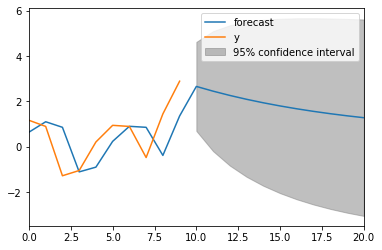

In [92]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Forecast the first AR(1) model
mod = ARMA(simulated_data_1, order=(1,0))
res = mod.fit()
res.plot_predict(start=990, end=1010)
plt.show();

Notice how, when phi is high like here, the forecast gradually moves to the long term mean of zero, but if phi were low, it would move much quicker to the long term mean. Try it out and see for yourself!

## Let's Forecast Interest Rates

You will now use the forecasting techniques you learned in the last exercise and apply it to real data rather than simulated data. You will revisit a dataset from the first chapter: the annual data of 10-year interest rates going back 56 years, which is in a Series called interest_rate_data. Being able to forecast interest rates is of enormous importance, not only for bond investors but also for individuals like new homeowners who must decide between fixed and floating rate mortgages.

You saw in the first chapter that there is some mean reversion in interest rates over long horizons. In other words, when interest rates are high, they tend to drop and when they are low, they tend to rise over time. Currently they are below long-term rates, so they are expected to rise, but an AR model attempts to quantify how much they are expected to rise.

In [99]:
df = pd.read_csv(path+'interest_rate_data.csv', parse_dates=True, index_col='DATE')
df.head()

,Unnamed: 1
DATE,
1962-12-31,3.85
1963-12-31,4.14
1964-12-31,4.21
1965-12-31,4.65
1966-12-31,4.64


/Users/ksatola/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


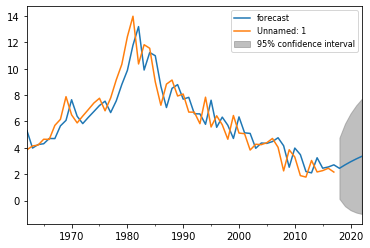

In [100]:
interest_rate_data = df

# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Forecast interest rates using an AR(1) model
mod = ARMA(interest_rate_data, order=(1,0))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(start=0, end='2022')
plt.legend(fontsize=8)
plt.show();

According to an AR(1) model, 10-year interest rates are forecasted to rise from 2.16%, towards the end of 2017 to 3.35% in five years.

## Compare AR Model with Random Walk

Sometimes it is difficult to distinguish between a time series that is slightly mean reverting and a time series that does not mean revert at all, like a random walk. You will compare the ACF for the slightly mean-reverting interest rate series of the last exercise with a simulated random walk with the same number of observations.

You should notice when plotting the autocorrelation of these two series side-by-side that they look very similar.

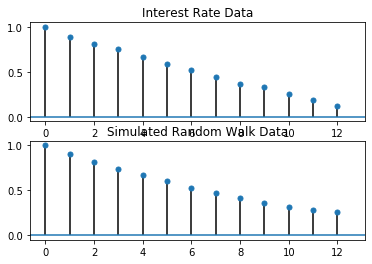

In [102]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot the interest rate series and the simulated random walk series side-by-side
fig, axes = plt.subplots(2,1)

# Plot the autocorrelation of the interest rate series in the top plot
fig = plot_acf(interest_rate_data, alpha=1, lags=12, ax=axes[0])

# Plot the autocorrelation of the simulated random walk series in the bottom plot
fig = plot_acf(simulated_data_1, alpha=1, lags=12, ax=axes[1])

# Label axes
axes[0].set_title("Interest Rate Data")
axes[1].set_title("Simulated Random Walk Data")
plt.show();

Notice the Autocorrelation functions look very similar for the two series.

## Choosing the Right Model

## Estimate Order of Model: PACF

One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF). In this exercise, you will simulate two time series, an AR(1) and an AR(2), and calculate the sample PACF for each. You will notice that for an AR(1), the PACF should have a significant lag-1 value, and roughly zeros after that. And for an AR(2), the sample PACF should have significant lag-1 and lag-2 values, and zeros after that.

Just like you used the plot_acf function in earlier exercises, here you will use a function called plot_pacf in the statsmodels module.

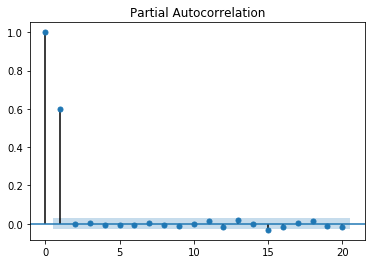

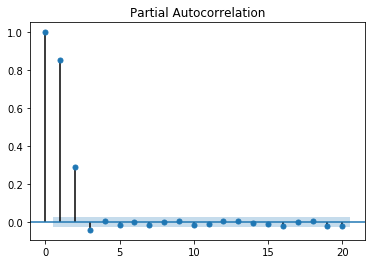

In [103]:
# Import the modules for simulating data and for plotting the PACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf

# Simulate AR(1) with phi=+0.6
ma = np.array([1])
ar = np.array([1, -0.6])
AR_object = ArmaProcess(ar, ma)
simulated_data_1 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(1)
plot_pacf(simulated_data_1, lags=20)
plt.show()

# Simulate AR(2) with phi1=+0.6, phi2=+0.3
ma = np.array([1])
ar = np.array([1, -0.6, -0.3])
AR_object = ArmaProcess(ar, ma)
simulated_data_2 = AR_object.generate_sample(nsample=5000)

# Plot PACF for AR(2)
plot_pacf(simulated_data_2, lags=20)
plt.show();

Notice that the number of significant lags for the PACF indicate the order of the AR model.

## Estimate Order of Model: Information Criteria

Another tool to identify the order of a model is to look at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). These measures compute the goodness of fit with the estimated parameters, but apply a penalty function on the number of parameters in the model. You will take the AR(2) simulated data from the last exercise, saved as simulated_data_2, and compute the BIC as you vary the order, p, in an AR(p) from 0 to 6.

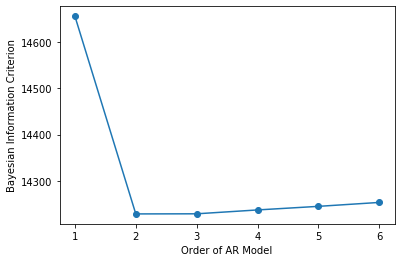

In [105]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(simulated_data_2, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show();

For an AR(2), the BIC achieves its minimum at p=2, which is what we expect.

---
<a id='ma'></a> 

## Moving Average (MA) and ARMA Models

## Describe Model

## Simulate MA(1) Time Series

You will simulate and plot a few MA(1) time series, each with a different parameter, θ, using the arima_process module in statsmodels, just as you did in the last chapter for AR(1) models. You will look at an MA(1) model with a large positive θ and a large negative θ.

As in the last chapter, when inputting the coefficients, you must include the zero-lag coefficient of 1, but unlike the last chapter on AR models, the sign of the MA coefficients is what we would expect. For example, for an MA(1) process with θ=−0.9, the array representing the MA parameters would be ma = np.array([1, -0.9])

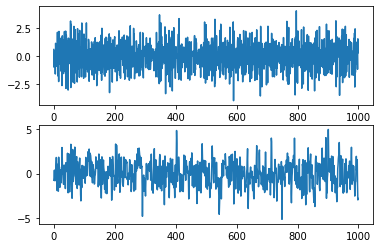

In [106]:
# import the module for simulating data
from statsmodels.tsa.arima_process import ArmaProcess

# Plot 1: MA parameter = -0.9
plt.subplot(2,1,1)
ar1 = np.array([1])
ma1 = np.array([1, -0.9])
MA_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = MA_object1.generate_sample(nsample=1000)
plt.plot(simulated_data_1)

# Plot 2: MA parameter = +0.9
plt.subplot(2,1,2)
ar2 = np.array([1])
ma2 = np.array([1, 0.9])
MA_object2 = ArmaProcess(ar2, ma2)
simulated_data_2 = MA_object2.generate_sample(nsample=1000)
plt.plot(simulated_data_2)

plt.show();

The two MA parameters produce different time series plots, but in the next exercise you'll really be able to distinguish the time series.

## Compute the ACF for Several MA Time Series

Unlike an AR(1), an MA(1) model has no autocorrelation beyond lag 1, an MA(2) model has no autocorrelation beyond lag 2, etc. The lag-1 autocorrelation for an MA(1) model is not θ, but rather θ/(1+θ2). For example, if the MA parameter, θ, is = +0.9, the first-lag autocorrelation will be 0.9/(1+(0.9)2)=0.497, and the autocorrelation at all other lags will be zero. If the MA parameter, θ, is -0.9, the first-lag autocorrelation will be −0.9/(1+(−0.9)2)=−0.497.

You will verify these autocorrelation functions for the three time series you generated in the last exercise.

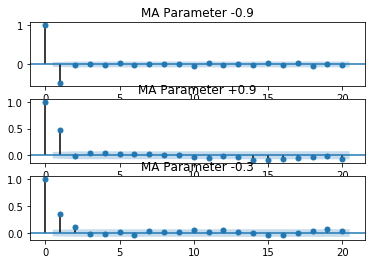

In [107]:
# Import the plot_acf module from statsmodels
from statsmodels.graphics.tsaplots import plot_acf

# Plot three ACF on same page for comparison using subplots
fig, axes = plt.subplots(3,1)

# Plot 1: AR parameter = -0.9
plot_acf(simulated_data_1, lags=20, ax=axes[0])
axes[0].set_title("MA Parameter -0.9")

# Plot 2: AR parameter = +0.9
plot_acf(simulated_data_2, lags=20, ax=axes[1])
axes[1].set_title("MA Parameter +0.9")

# Plot 3: AR parameter = -0.3
plot_acf(simulated_data_3, lags=20, ax=axes[2])
axes[2].set_title("MA Parameter -0.3")
plt.show();

## Match ACF with MA Model

Here are four Autocorrelation plots. Which figure corresponds to an MA(1) model with an MA parameter of -0.5?

<img src="images/ts_006.png" alt="" style="width: 400px;"/>

Correct: D

## Estimation and Forecasting an MA Model

## Estimating an MA Model
You will estimate the MA(1) parameter, θ, of one of the simulated series that you generated in the earlier exercise. Since the parameters are known for a simulated series, it is a good way to understand the estimation routines before applying it to real data.

For simulated_data_1 with a true θ of -0.9, you will print out the estimate of θ. In addition, you will also print out the entire output that is produced when you fit a time series, so you can get an idea of what other tests and summary statistics are available in statsmodels.

In [108]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Fit an MA(1) model to the first simulated data
mod = ARMA(simulated_data_1, order=(0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for theta
print("When the true theta=-0.9, the estimate of theta (and the constant) are:")
print(res.params)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.363
Method:                       css-mle   S.D. of innovations              0.971
Date:                Sat, 09 Nov 2019   AIC                           2786.727
Time:                        18:45:06   BIC                           2801.450
Sample:                             0   HQIC                          2792.323
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.003      0.467      0.641      -0.004       0.007
ma.L1.y       -0.9091      0.014    -63.209      0.000      -0.937      -0.881
                                    Roots           

Notice how close the estimated parameter is to the true parameter.

## Forecasting with MA Model
As you did with AR models, you will use MA models to forecast in-sample and out-of-sample data using statsmodels.

For the simulated series simulated_data_1 with θ=−0.9, you will plot in-sample and out-of-sample forecasts. One big difference you will see between out-of-sample forecasts with an MA(1) model and an AR(1) model is that the MA(1) forecasts more than one period in the future are simply the mean of the sample.

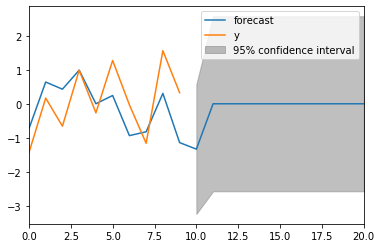

In [109]:
# Import the ARMA module from statsmodels
from statsmodels.tsa.arima_model import ARMA

# Forecast the first MA(1) model
mod = ARMA(simulated_data_1, order=(0,1))
res = mod.fit()
res.plot_predict(start=990, end=1010)
plt.show();

Notice that the out-of-sample forecasts are flat into the future after the first data point.

## High Frequency Stock Prices

Higher frequency stock data is well modeled by an MA(1) process, so it's a nice application of the models in this chapter.

The DataFrame intraday contains one day's prices (on September 1, 2017) for Sprint stock (ticker symbol "S") sampled at a frequency of one minute. The stock market is open for 6.5 hours (390 minutes), from 9:30am to 4:00pm.

Before you can analyze the time series data, you will have to clean it up a little, which you will do in this and the next two exercises. When you look at the first few rows (see the IPython Shell), you'll notice several things. First, there are no column headers.The data is not time stamped from 9:30 to 4:00, but rather goes from 0 to 390. And you will notice that the first date is the odd-looking "a1504272600". The number after the "a" is Unix time which is the number of seconds since January 1, 1970. This is how this dataset separates each day of intraday data.

If you look at the data types, you'll notice that the DATE column is an object, which here means a string. You will need to change that to numeric before you can clean up some missing data.

The source of the minute data is Google Finance (see here on how the data was downloaded).

The datetime module has already been imported for you.

In [113]:
df = pd.read_csv(path+'intraday.csv', index_col=0)
df.head()

,0,1
0,a1504272600,8.2900
1,1,8.2700
2,2,8.2800
3,3,8.2750
4,4,8.2875


In [115]:
intraday = df

# import datetime module
import datetime

# Change the first date to zero
intraday.iloc[0,0] = 0

# Change the column headers to 'DATE' and 'CLOSE'
intraday.columns = ['DATE','CLOSE']

# Examine the data types for each column
print(intraday.dtypes)

# Convert DATE column to numeric
intraday['DATE'] = pd.to_numeric(intraday['DATE'])

# Make the `DATE` column the new index
intraday = intraday.set_index('DATE')

DATE      object
CLOSE    float64
dtype: object


## More Data Cleaning: Missing Data

When you print out the length of the DataFrame intraday, you will notice that a few rows are missing. There will be missing data if there are no trades in a particular one-minute interval. One way to see which rows are missing is to take the difference of two sets: the full set of every minute and the set of the DataFrame index which contains missing rows. After filling in the missing rows, you can convert the index to time of day and then plot the data.

Stocks trade at discrete one-cent increments (although a small percentage of trades occur in between the one-cent increments) rather than at continuous prices, and when you plot the data you should observe that there are long periods when the stock bounces back and forth over a one cent range. This is sometimes referred to as "bid/ask bounce".

The length of the DataFrame is:  389
Missing rows:  {182, 14}


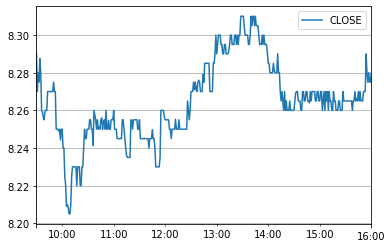

In [116]:
# Notice that some rows are missing
print("The length of the DataFrame is: ",len(intraday))

# Find the missing rows
print("Missing rows: ", set(range(391)) - set(intraday.index))

# Fill in the missing rows
intraday = intraday.reindex(range(391), method='ffill')

# Change the index to the intraday times
intraday.index = pd.date_range(start='2017-09-01 9:30', end='2017-09-01 16:00', freq='1min')

# Plot the intraday time series
intraday.plot(grid=True)
plt.show();

Missing data is common with high frequency financial time series, so good job fixing that.

## Applying an MA Model

The bouncing of the stock price between bid and ask induces a negative first order autocorrelation, but no autocorrelations at lags higher than 1. You get the same ACF pattern with an MA(1) model. Therefore, you will fit an MA(1) model to the intraday stock data from the last exercise.

The first step is to compute minute-by-minute returns from the prices in intraday, and plot the autocorrelation function. You should observe that the ACF looks like that for an MA(1) process. Then, fit the data to an MA(1), the same way you did for simulated data.

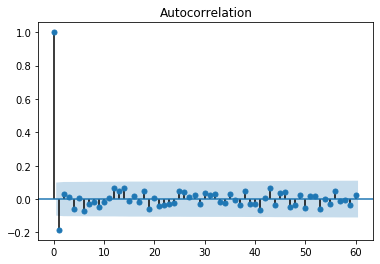

const         -0.000002
ma.L1.CLOSE   -0.179272
dtype: float64


In [117]:
# Import plot_acf and ARMA modules from statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA

# Compute returns from prices and drop the NaN
returns = intraday.pct_change()
returns = returns.dropna()

# Plot ACF of returns with lags up to 60 minutes
plot_acf(returns, lags=60)
plt.show()

# Fit the data to an MA(1) model
mod = ARMA(returns, order=(0,1))
res = mod.fit()
print(res.params)

Notice the significant negative lag-1 autocorrelation, just like for an MA(1) model.

## Equivalence of AR(1) and MA(infinity)

To better understand the relationship between MA models and AR models, you will demonstrate that an AR(1) model is equivalent to an MA(∞) model with the appropriate parameters.

You will simulate an MA model with parameters 0.8,0.82,0.83,… for a large number (30) lags and show that it has the same Autocorrelation Function as an AR(1) model with ϕ=0.8.

Note, to raise a number x to the power of an exponent n, use the format x**n.

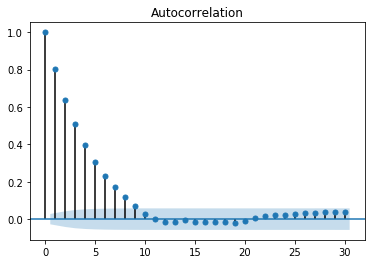

In [118]:
# import the modules for simulating data and plotting the ACF
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf

# Build a list MA parameters
ma = [0.8**i for i in range(30)]

# Simulate the MA(30) model
ar = np.array([1])
AR_object = ArmaProcess(ar, ma)
simulated_data = AR_object.generate_sample(nsample=5000)

# Plot the ACF
plot_acf(simulated_data, lags=30)
plt.show();

Notice that the ACF looks the same as an AR(1) with parameter 0.8.

---
<a id='all'></a> 

## Putting It All Together

## Cointegration Models

## A Dog on a Leash? (Part 1)

The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG. First, plot both price series, which look like random walks. Then plot the difference between the two series, which should look more like a mean reverting series (to put the two series in the same units, we multiply the heating oil prices, in $/gallon, by 7.25, which converts it to $/millionBTU, which is the same units as Natural Gas).

The data for continuous futures (each contract has to be spliced together in a continuous series as contracts expire) was obtained from [Quandl](https://blog.quandl.com/api-for-futures-data).

In [132]:
HO = pd.read_csv(path+'HO.csv', index_col=0)
HO.head()

,Close
Date,
1991-01-02,0.7330
1991-01-03,0.7024
1991-01-04,0.6830
1991-01-07,0.7617
1991-01-08,0.7430


In [133]:
NG = pd.read_csv(path+'NG.csv', index_col=0)
NG.head()

,Close
Date,
1991-01-02,1.832
1991-01-03,1.782
1991-01-04,1.743
1991-01-07,1.785
1991-01-08,1.786


In [134]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25*HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25*HO-NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show();

KeyboardInterrupt: 

Notice from the plot that when Heating Oil briefly dipped below Natural Gas, it quickly reverted back up.

## A Dog on a Leash? (Part 2)

To verify that Heating Oil and Natural Gas prices are cointegrated, First apply the Dickey-Fuller test separately to show they are random walks. Then apply the test to the difference, which should strongly reject the random walk hypothesis. The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG.

In [128]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Compute the ADF for HO and NG
result_HO = adfuller(HO['Close'])
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO['Close'] - NG['Close'])
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.9567108785017872
The p-value for the ADF test on NG is  0.9008747444676731
The p-value for the ADF test on the spread is  7.01943930214218e-05


As we expected, we cannot reject the hypothesis that the individual futures are random walks, but we can reject that the spread is a random walk.

## Are Bitcoin and Ethereum Cointegrated?

Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was (1,−1). In other words, we took the difference between the two series (after doing a units conversion). Here, you will do both steps.

You will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call the regression coefficient b, then the cointegration vector is simply (1,−b). Then perform the ADF test on BTC −b ETH. Bitcoin and Ethereum prices are pre-loaded in DataFrames BTC and ETH.

In [129]:
BTC = pd.read_csv(path+'BTC.csv', index_col=0)
BTC.head()

,Price
Date,
2015-09-29,236.9
2015-09-30,237.1
2015-10-01,238.3
2015-10-02,238.3
2015-10-03,239.9


In [130]:
ETH = pd.read_csv(path+'ETH.csv', index_col=0)
ETH.head()

,Price
Date,
2015-09-29,0.68
2015-09-30,0.71
2015-10-01,0.65
2015-10-02,0.66
2015-10-03,0.68


In [131]:
# Import the statsmodels module for regression and the adfuller function
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(BTC['Price'] - b*ETH['Price'])
print("The p-value for the ADF test is ", adf_stats[1])
# The data suggests that Bitcoin and Ethereum are cointegrated

The p-value for the ADF test is  0.02336900232347285


/Users/ksatola/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The data suggests that Bitcoin and Ethereum are cointegrated.

---
<a id='climate'></a> 

## Case Study: Climate Change

## Is Temperature a Random Walk (with Drift)?

An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.

The DataFrame temp_NY contains the average annual temperature in Central Park, NY from 1870-2016 (the data was downloaded from the NOAA [here](https://www.ncdc.noaa.gov/cdo-web/search)). Plot the data and test whether it follows a random walk (with drift).

In [138]:
temp_NY = pd.read_csv(path+'Temp_NY.csv', index_col=0)
temp_NY.head()

,TAVG
DATE,
1870,53.8
1871,51.3
1872,51.3
1873,50.9
1874,51.3


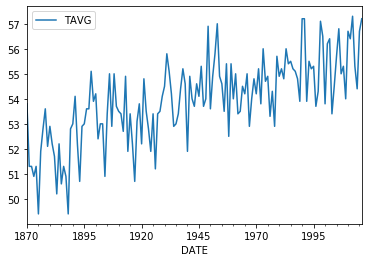

The p-value for the ADF test is  0.5832938987871152


In [139]:
# Import the adfuller function from the statsmodels module
from statsmodels.tsa.stattools import adfuller

# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

The data seems to follow a random walk with drift.

## Getting "Warmed" Up: Look at Autocorrelations

Since the temperature series, temp_NY, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

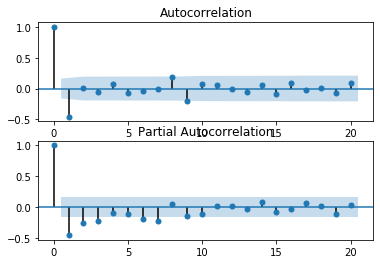

In [143]:
# Import the modules for plotting the sample ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the ACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show();

There is no clear pattern in the ACF and PACF except the negative lag-1 autocorrelation in the ACF.

## Which ARMA Model is Best?

Recall that the `Akaike Information Criterion (AIC)` can be used to compare models with different numbers of parameters. It measures **goodness-of-fit**, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

The annual change in temperature is in a DataFrame chg_temp.

In [145]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(chg_temp, order=(1,0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARMA(chg_temp, order=(2,0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an MA(1) model and print AIC:
mod_arma11 = ARMA(chg_temp, order=(0,1))
res_arma11 = mod_arma11.fit()
print("The AIC for an MA(1) is: ", res_arma11.aic)

The AIC for an AR(1) is:  510.534689831391
The AIC for an AR(2) is:  501.92741231602264
The AIC for an MA(1) is:  469.3909708062573


/Users/ksatola/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Users/ksatola/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Users/ksatola/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


The ARMA(1,1) has the lowest AIC values among the three models.

## Don't Throw Out That Winter Coat Yet
Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

The data is preloaded in a DataFrame called temp_NY.

/Users/ksatola/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/Users/ksatola/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


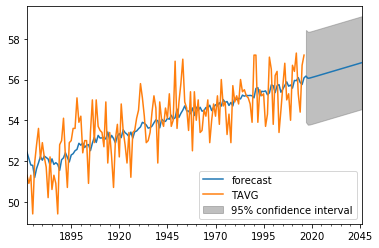

In [146]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima_model import ARIMA

# Forecast interest rates using an AR(1) model
mod = ARIMA(temp_NY, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(start='1872-01-01', end='2046-01-01')
plt.show();

According to the model, the temperature is expected to be about 0.6 degrees higher in 30 years (almost entirely due to the trend), but the 95% confidence interval around that is over 5 degrees.